# Pytorch + Pytorch Lightning + Ray Tune

In this notebook, we first train, validate, and predict on Titanic problem using the default `Pytorch` framework.

Next, we update and replace the boilerplate codes using the `Pytorch Lightning` framework.

Last, we combine the `Pytorch Lightning` with the `Ray Tune` (a `Hyperparameter Tuning` framework) to find the best hyperparameters.

# 😺 Basic Pytorch



In [1]:
!pip install sweetviz
!pip install scikit-learn==0.23.1
import numpy as np
import pandas as pd
import sweetviz as sv
import os
import warnings
from IPython.display import clear_output
warnings.filterwarnings('ignore')
clear_output()

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

In [3]:
from pathlib import Path
root_dir = Path("/kaggle")
data_dir = root_dir / "input/titanic"
ckpt_dir = root_dir / "working/checkpoints"
log_dir = root_dir / "working/logs"
submission_dir = root_dir / "working/submissions"
list(root_dir.iterdir())

[PosixPath('/kaggle/src'),
 PosixPath('/kaggle/lib'),
 PosixPath('/kaggle/input'),
 PosixPath('/kaggle/working')]

## 1  Data Preprocessing

### 1.1 Loading Data

In [4]:
train_data = pd.read_csv(data_dir / "train.csv")
test_data = pd.read_csv(data_dir / "test.csv")

In [5]:
train_data.iloc[:3]

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

### 1.2 Data Preview

First, we use library `sweetviz` to do a quick data exploration on the titanic dataset.

1. Values in `age` are missing 177 (20%) in `train_data` and 86 (21%) in `test_data`. 
2. Values in `cabin` are missing 687 (77%) and 327 (78%) in both datasets.
3. The features that have the most impact on `Survived` are `Sex` and `Fare`.


                                             |          | [  0%]   00:00 -> (? left)


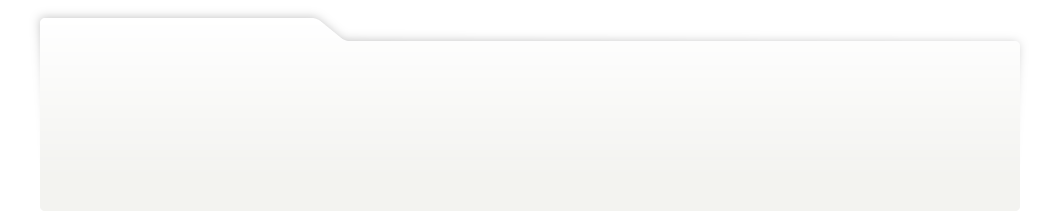
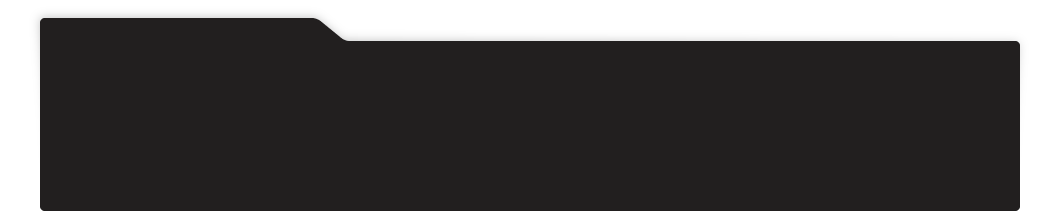
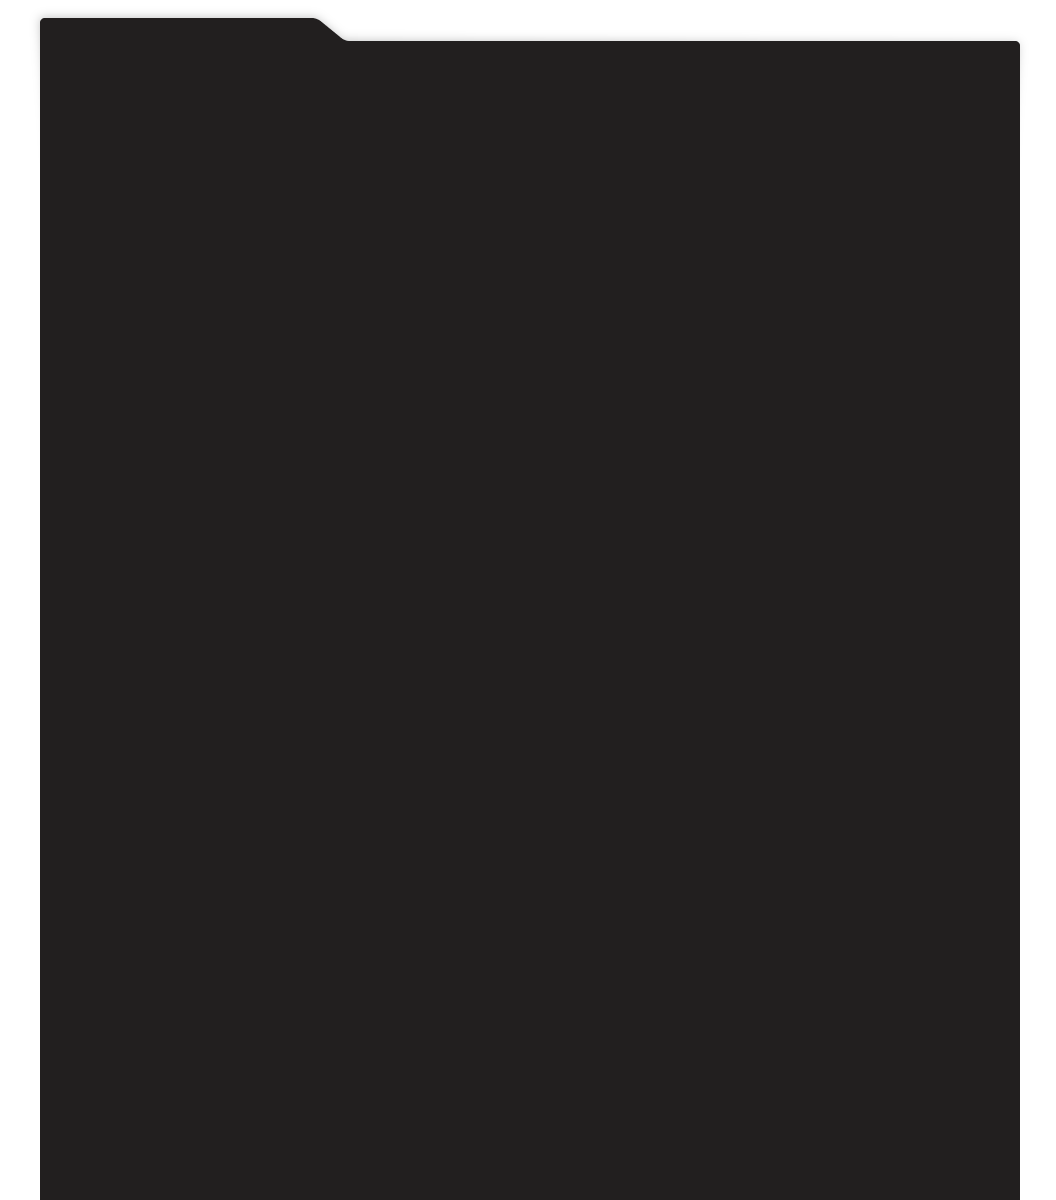
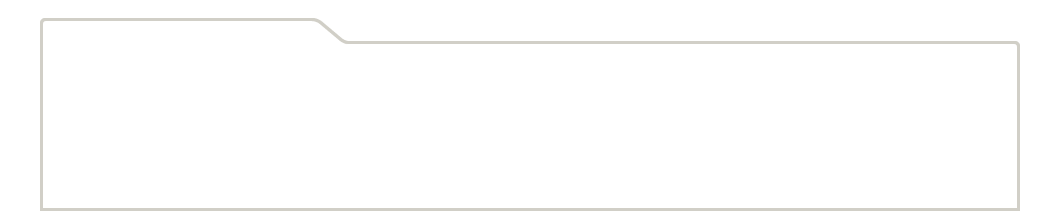
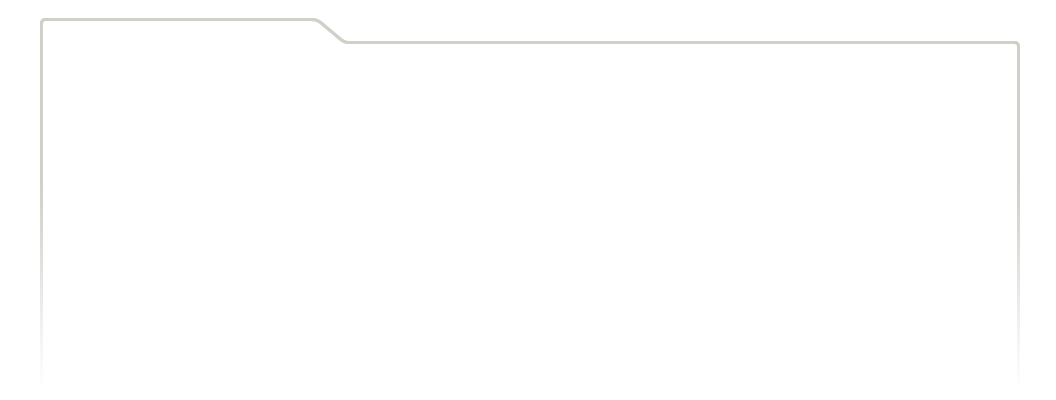
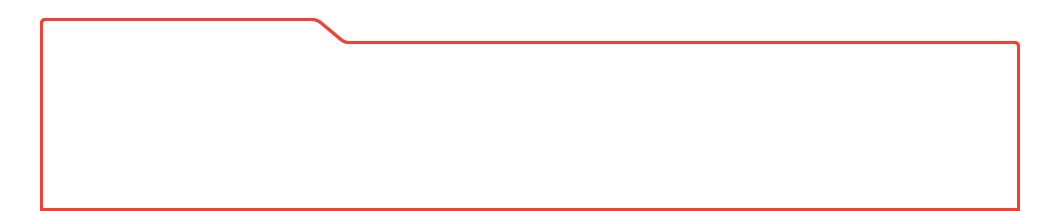
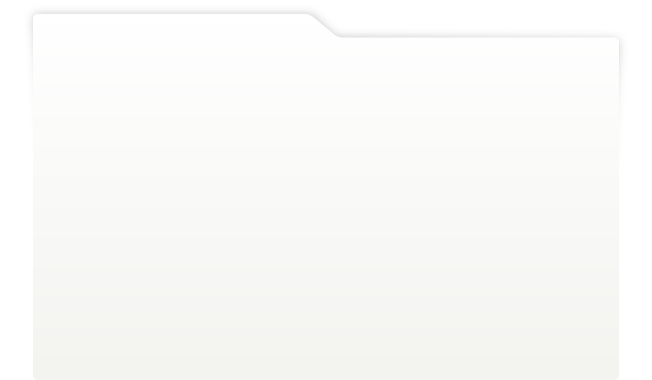
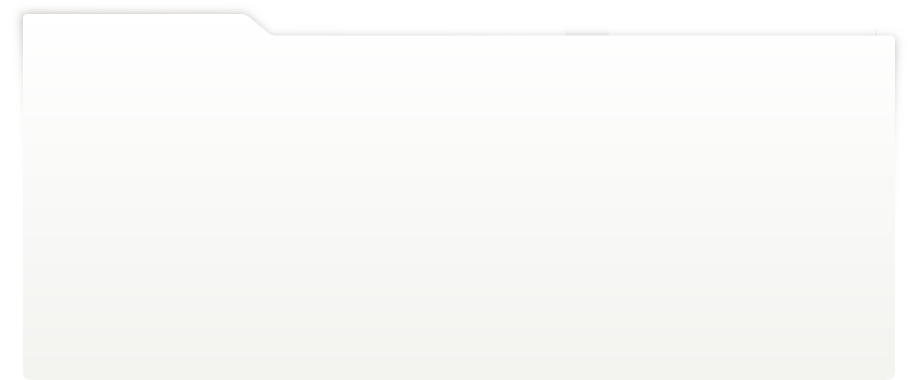
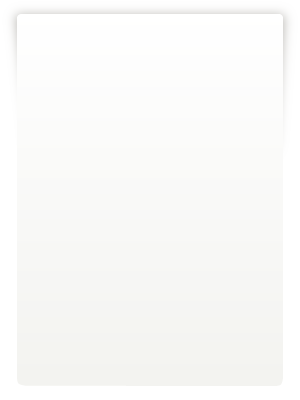
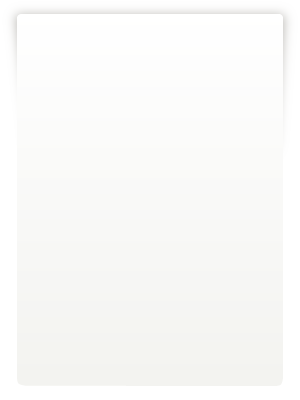
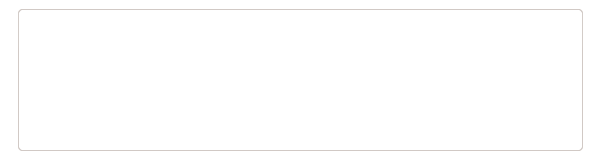
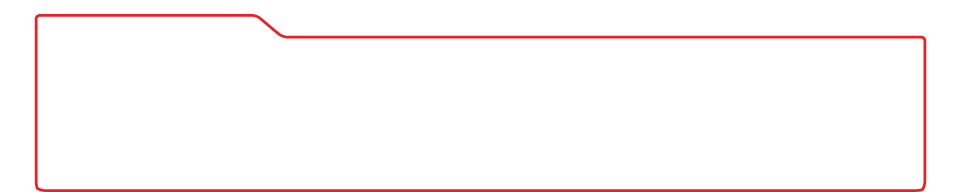
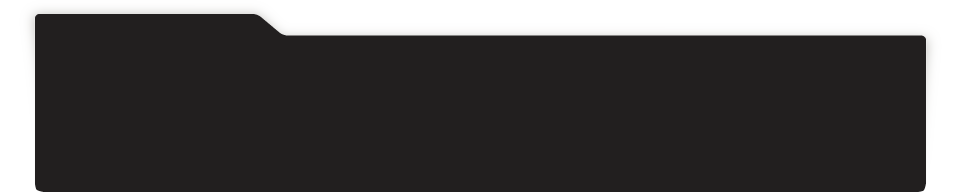
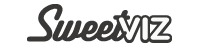
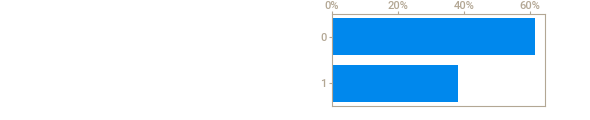
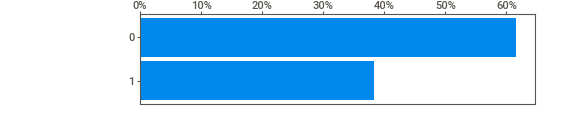
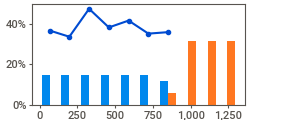
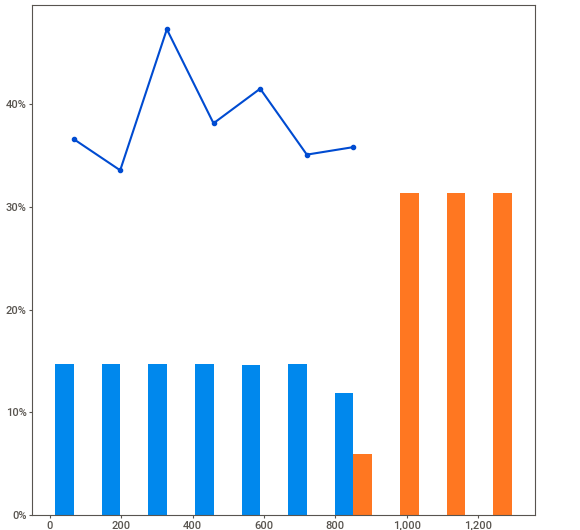
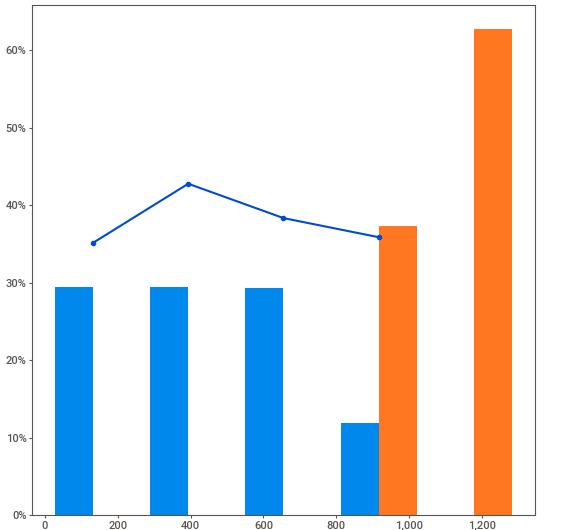
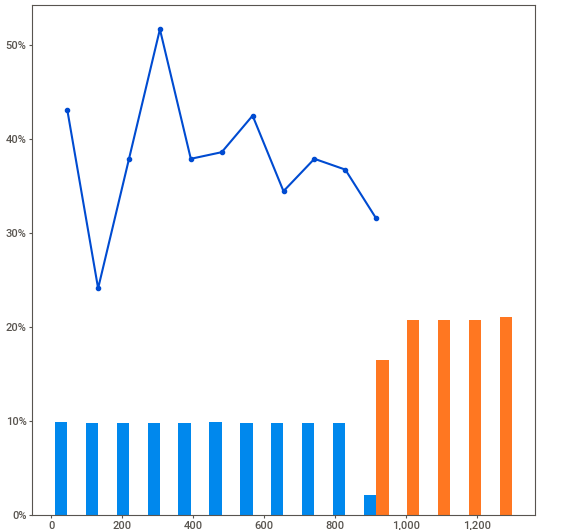
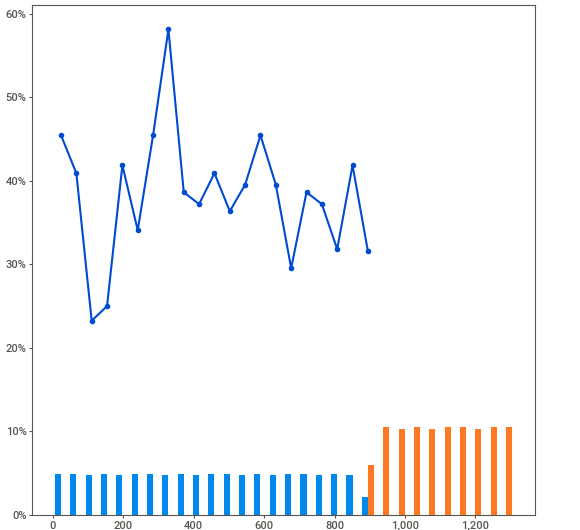
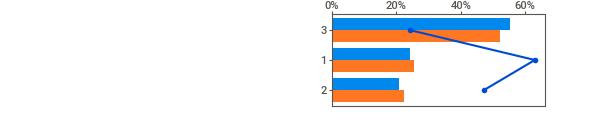
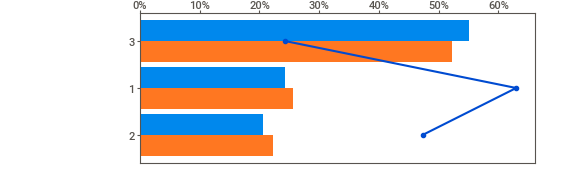
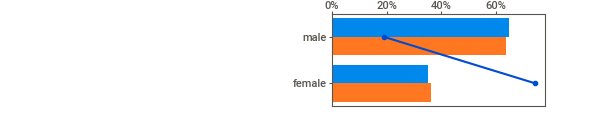
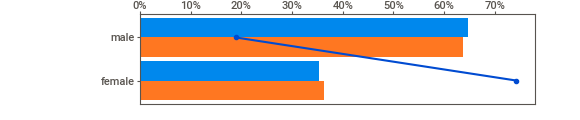
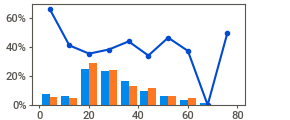
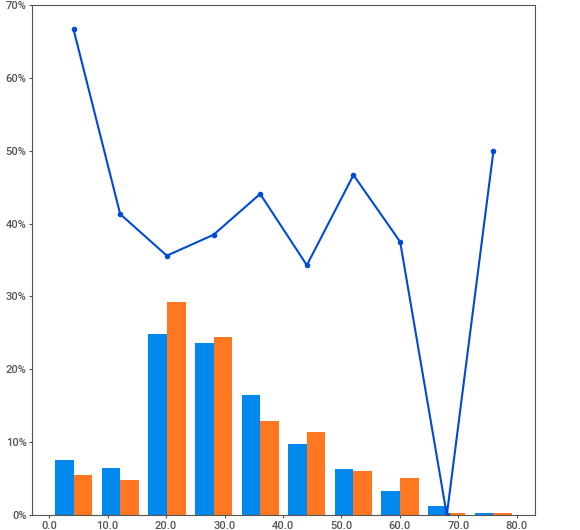
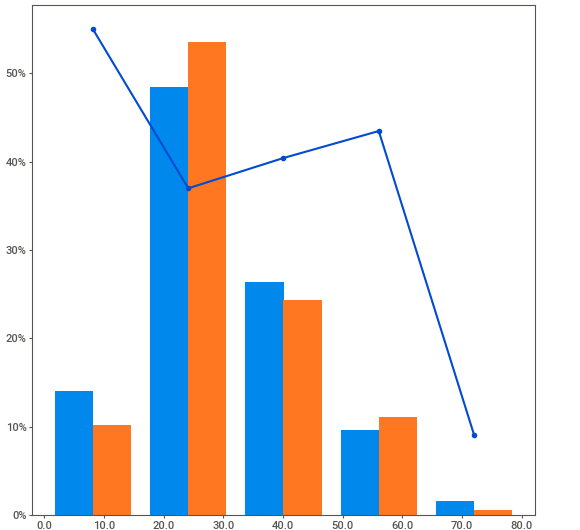
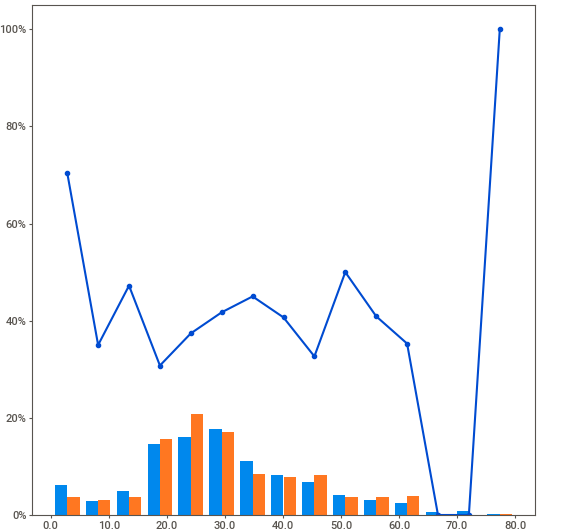
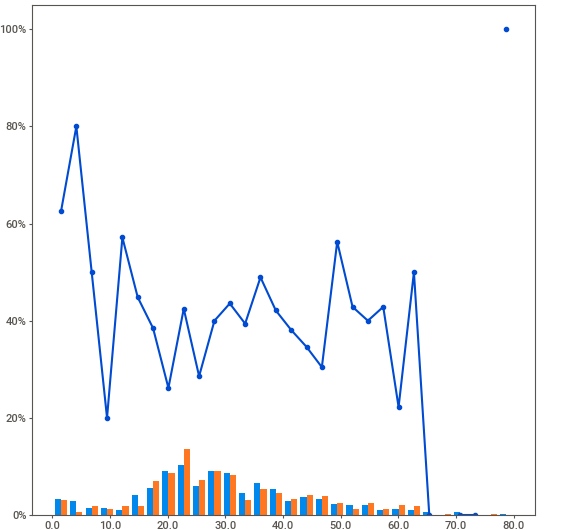
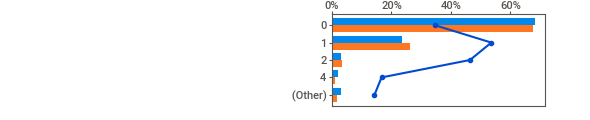
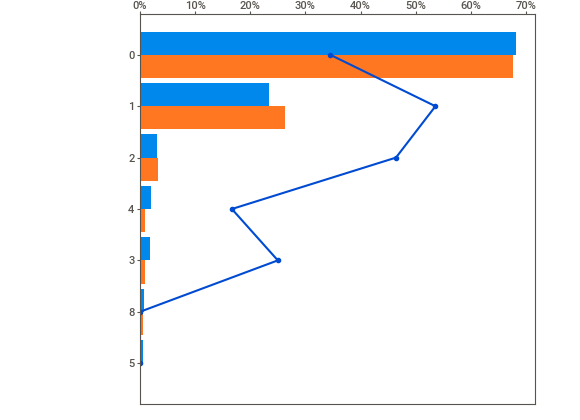
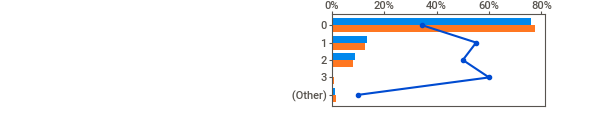
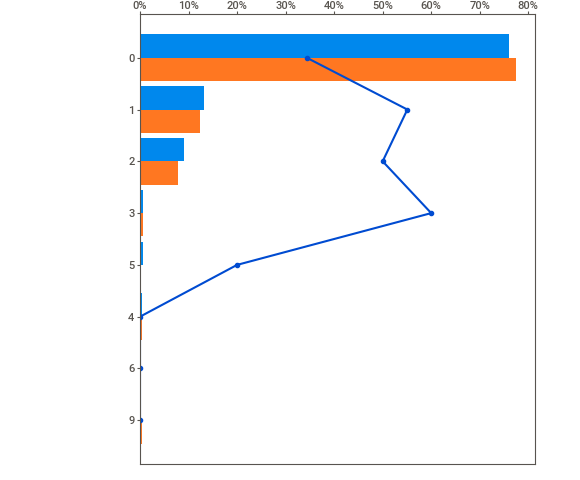
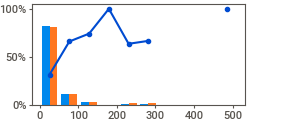
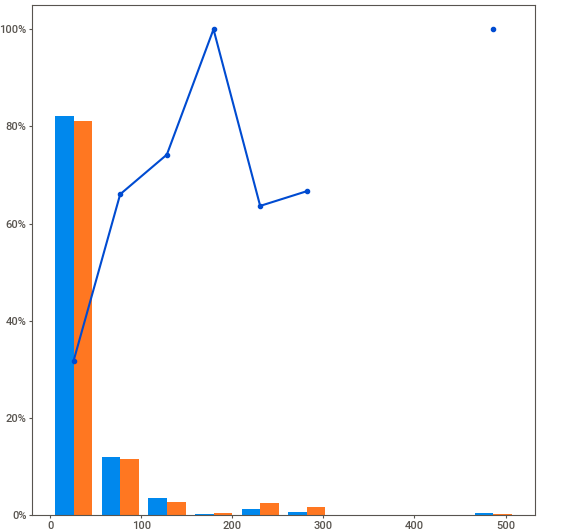
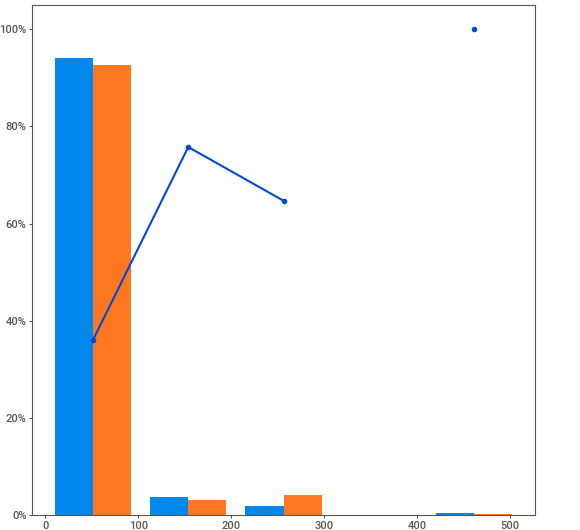
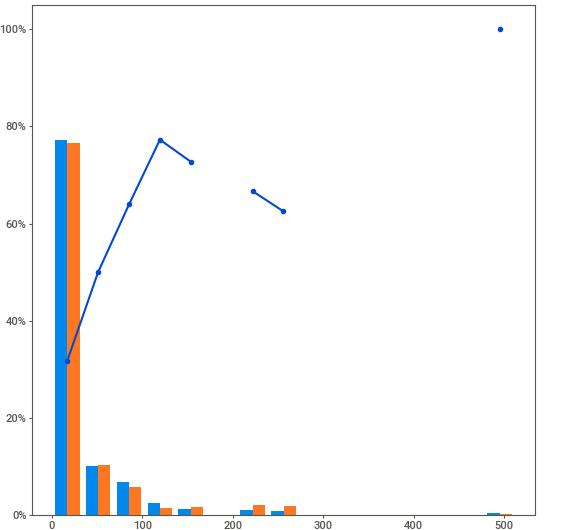
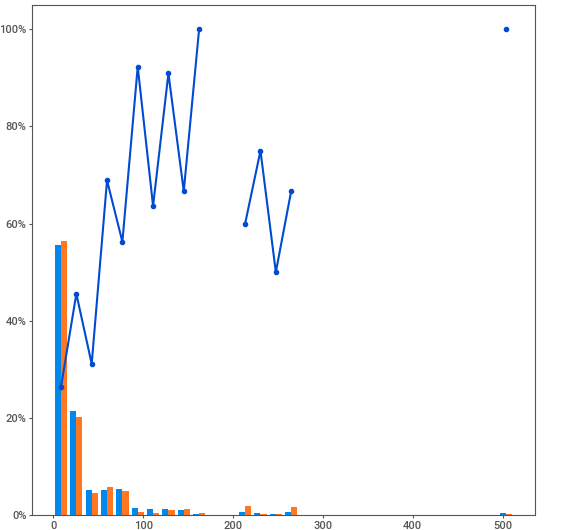
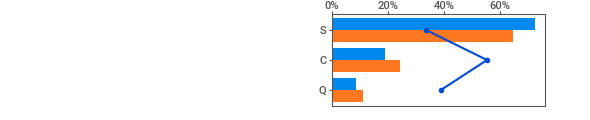
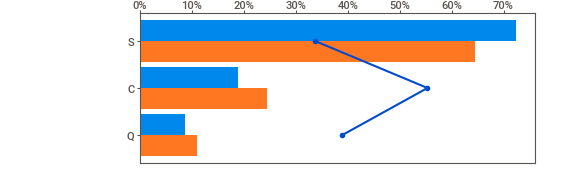
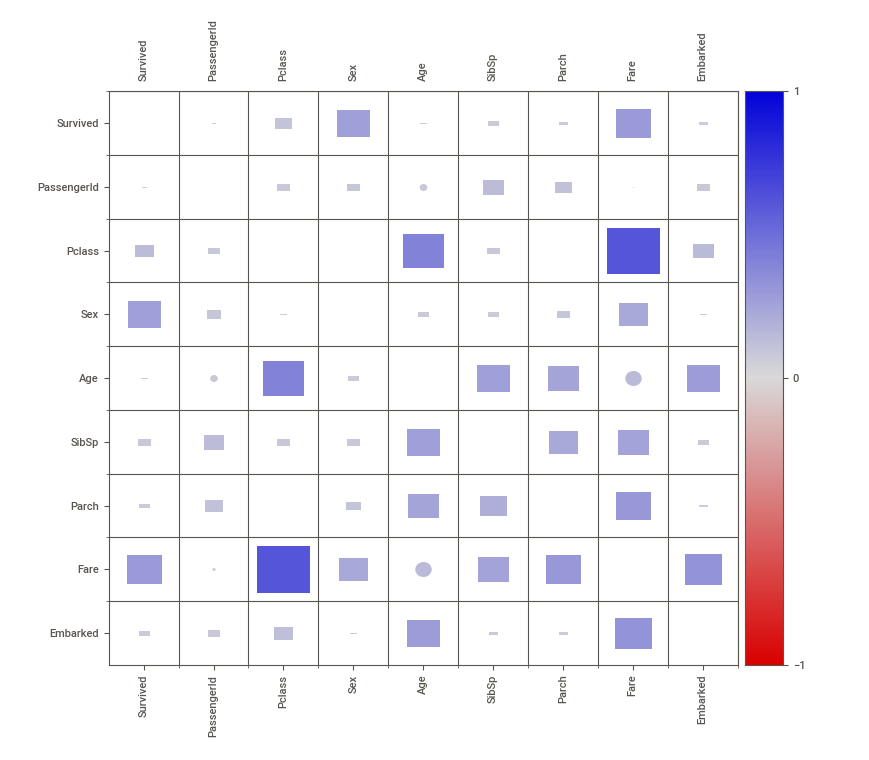
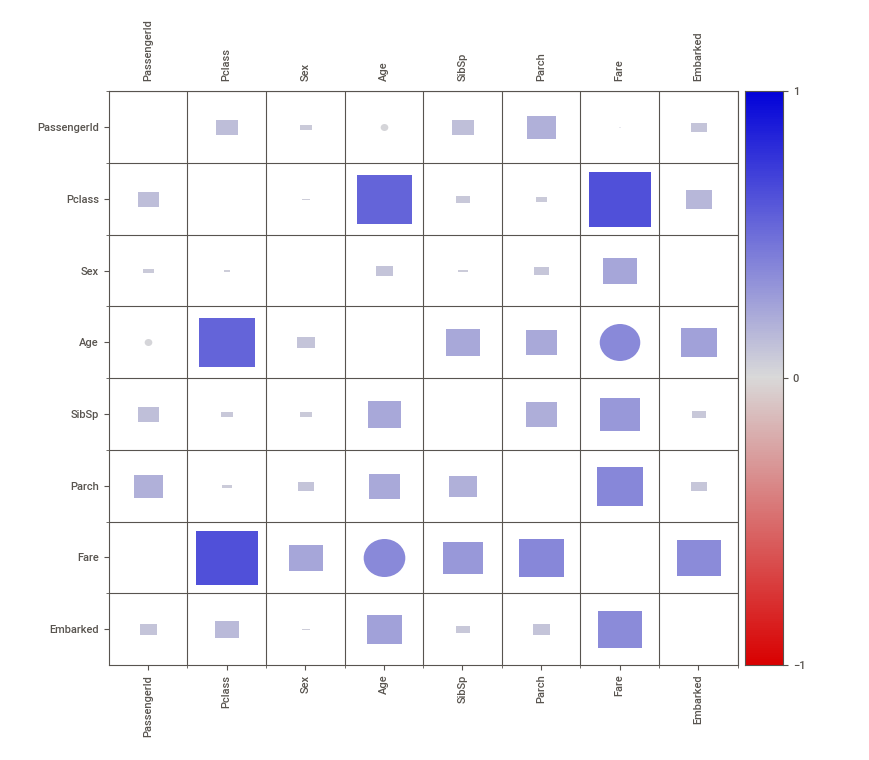

In [6]:
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat="Survived", pairwise_analysis="on")
report.show_notebook()

### 1.3 Data Completing, Data Cleaning, Data Creating

#### Completing

We fill the missing values of `age`, `embarked`, `fare` in both `train_data` and `test_data` with **median** and **mode** respectively.

#### Cleaning

Then we drop the `id`, `cabin`, `ticket` columns from both dataset because:

1. `PassengerId` has no meaning.
2. `Cabin` has too many missing values.
3. `Ticket` has no meaning from its distribution. (maybe)

#### Creating (Feature Engineering)

We extract the information from `SibSp` and `Parch`, then create two new features: `FamilySize` and `IsAlone`.

From the `Name` feature, we can get the `Title` of each person. After the extraction, we can drop the `Name` column.

Finally, we use `qcut()` and `cut()` from pandas, to convert the `Age` and `Fare` into discrete intervals, then we drop the `Age` and `Fare`.

> - [pandas的cut&qcut函數](https://medium.com/@morris_tai/pandas%E7%9A%84cut-qcut%E5%87%BD%E6%95%B8-93c244e34cfc)
> - [pandas的cut，qcut函数的使用和区别](https://zhuanlan.zhihu.com/p/68194655)


In [7]:
data_cleaner = [train_data, test_data]

In [8]:
test_ids = test_data["PassengerId"]

for dataset in data_cleaner:
    # Data Completing
    dataset["Age"].fillna(dataset["Age"].median(), inplace=True)
    dataset["Embarked"].fillna(dataset["Embarked"].mode()[0], inplace=True)
    dataset["Fare"].fillna(dataset["Fare"].median(), inplace = True)

    # Data Cleaning
    drop_column = ['PassengerId', 'Cabin', 'Ticket']
    dataset.drop(drop_column, axis=1, inplace=True)

    # Data Creating (Feature Engineering)
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1  #initialize to 1 = is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0  # now update to no if family size is greater than 1

    dataset['Title'] = dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_counts = dataset['Title'].value_counts() < 10
    dataset["Title"] = dataset["Title"].apply(lambda x: "Misc" if title_counts.loc[x] == True else x)

    ## Divide the `Fare` into 4 intervals with similar quantities.
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4, labels=False)

    ## Divide the `Age` into 4 discrete intervals according to its value.
    dataset['AgeBin'] = pd.cut(dataset['Age'], [0, 25, 50, 75, 100], labels=False)

    ## Drop these columns since we have these features in the discrete version.
    dataset.drop(columns=["Name", "Age", "Fare"], inplace=True)

In [9]:
train_data.sample(5)

Survived  Pclass     Sex  SibSp  Parch Embarked  FamilySize  IsAlone  \
612         1       3  female      1      0        Q           2        0   
531         0       3    male      0      0        C           1        1   
398         0       2    male      0      0        S           1        1   
424         0       3    male      1      1        S           3        0   
617         0       3  female      1      0        S           2        0   

    Title  FareBin  AgeBin  
612  Miss        2       1  
531    Mr        0       1  
398  Misc        1       0  
424    Mr        2       0  
617   Mrs        2       1

### 1.4 Data Labeling

In this step, we have to convert the features: `Sex`, `Title`, and `Embarked` into **discrete form** by using `sklearn.preprocessing.LabelEncoder`.

In [10]:
for dataset in data_cleaner:
    label_encoder = LabelEncoder()
    dataset["Sex"] = label_encoder.fit_transform(dataset["Sex"])
    dataset["Title"] = label_encoder.fit_transform(dataset["Title"])
    dataset["Embarked"] = label_encoder.fit_transform(dataset["Embarked"])

In [11]:
train_data

Survived  Pclass  Sex  SibSp  Parch  Embarked  FamilySize  IsAlone  \
0           0       3    1      1      0         2           2        0   
1           1       1    0      1      0         0           2        0   
2           1       3    0      0      0         2           1        1   
3           1       1    0      1      0         2           2        0   
4           0       3    1      0      0         2           1        1   
..        ...     ...  ...    ...    ...       ...         ...      ...   
886         0       2    1      0      0         2           1        1   
887         1       1    0      0      0         2           1        1   
888         0       3    0      1      2         2           4        0   
889         1       1    1      0      0         0           1        1   
890         0       3    1      0      0         1           1        1   

     Title  FareBin  AgeBin  
0        3        0       0  
1        4        3       1  
2        2        1       1  
3        4        3       1  
4        3        1       1  
..     ...      ...     ...  
886      1        1       1  
887      2        2       0  
888      2        2       1  
889      3        2       1  
890      3        0       1  

[891 rows x 11 columns]

                                             |          | [  0%]   00:00 -> (? left)


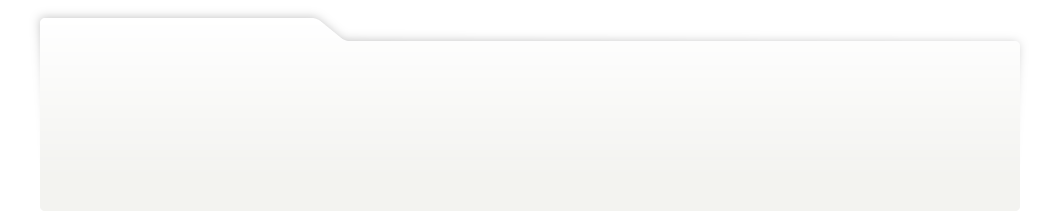
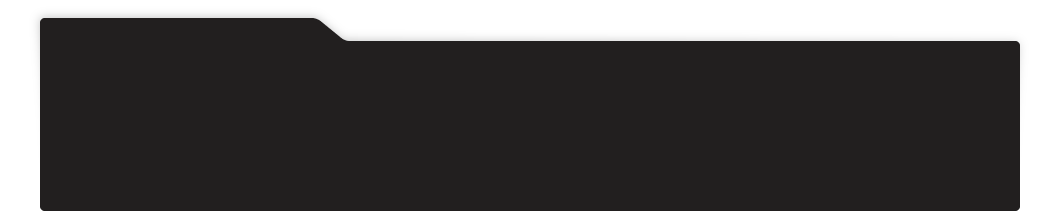
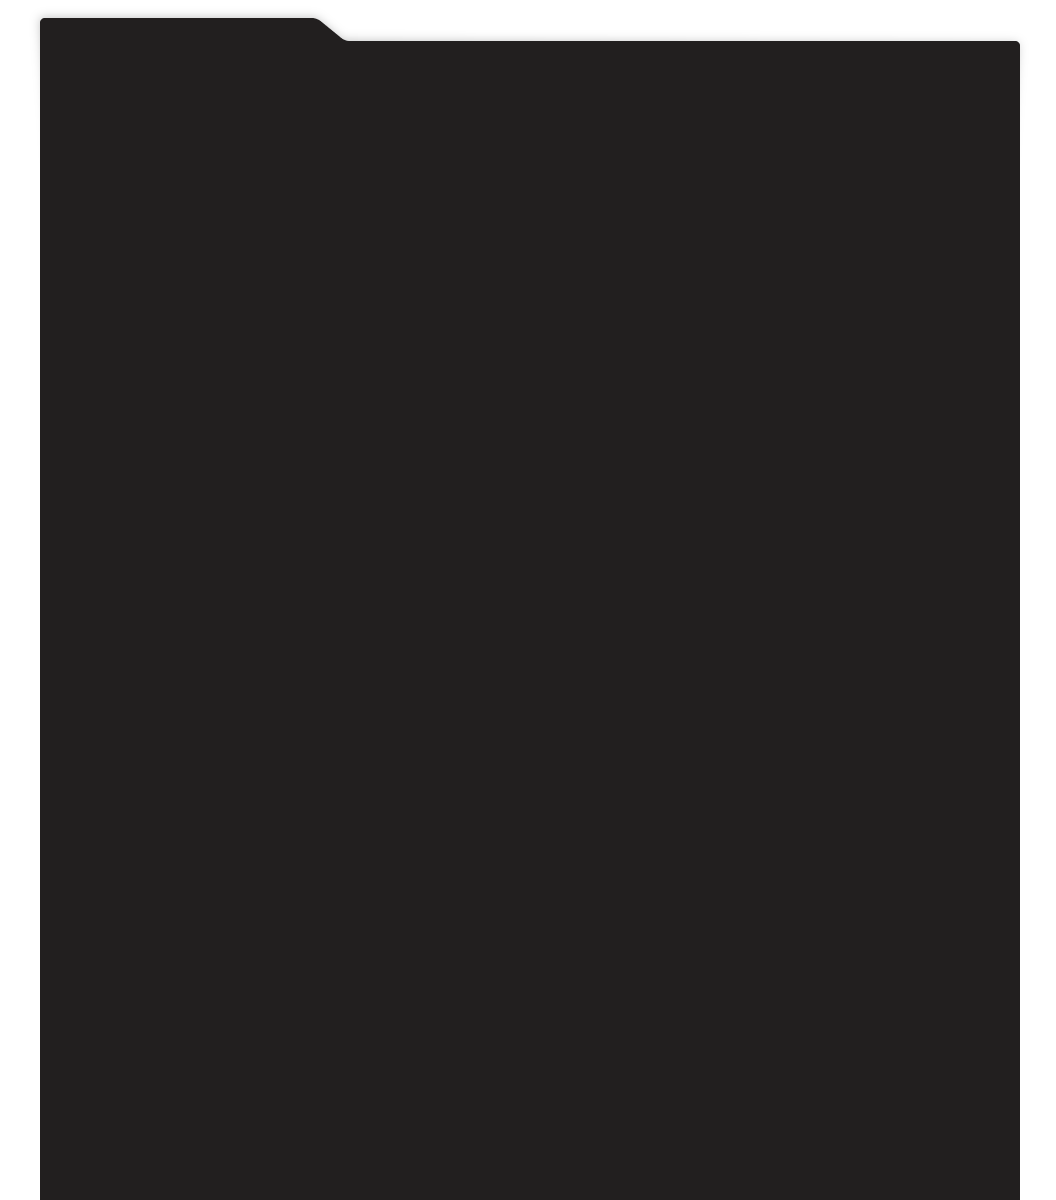
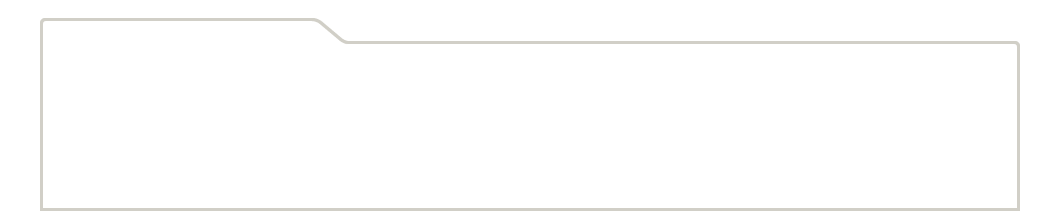
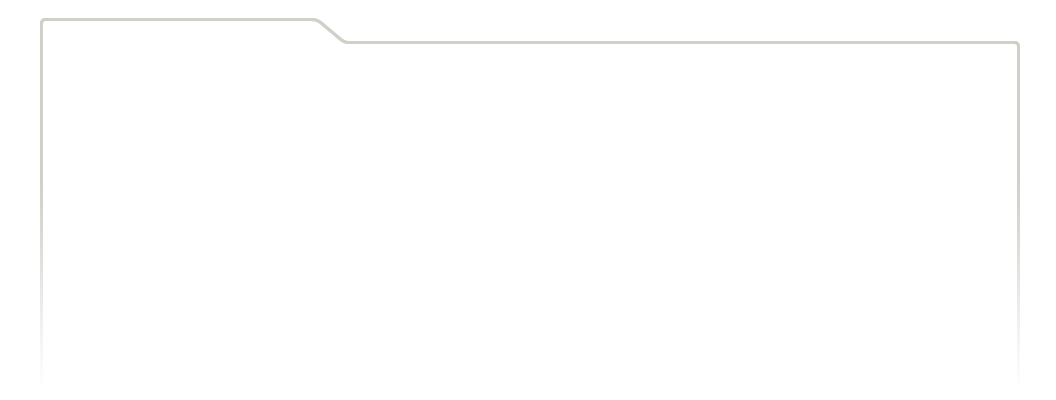
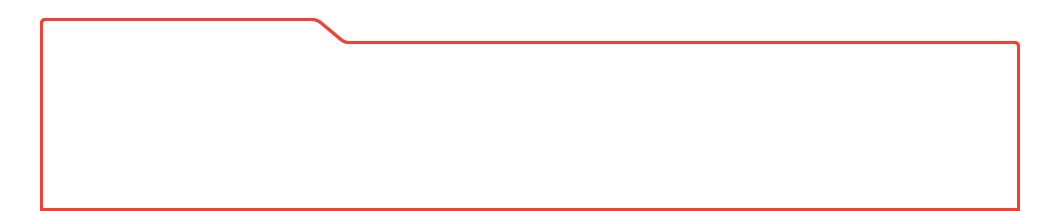
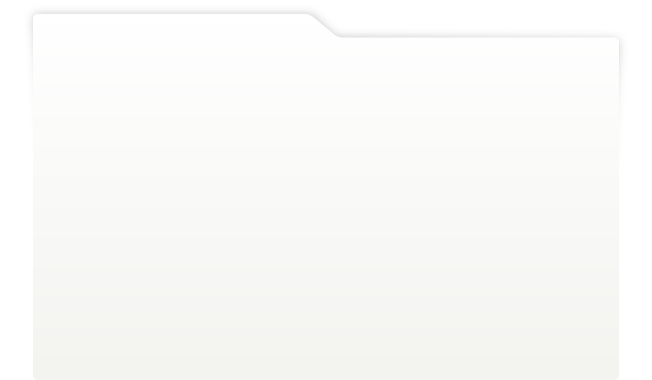
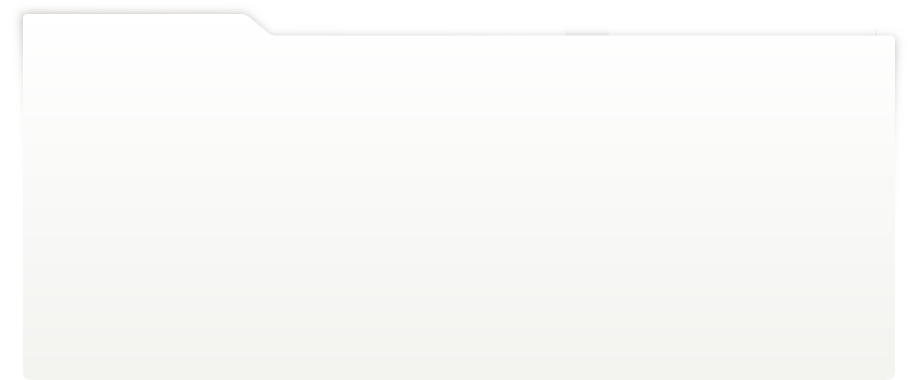
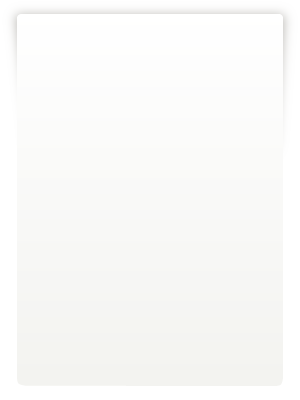
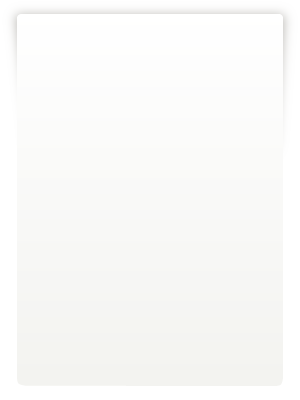
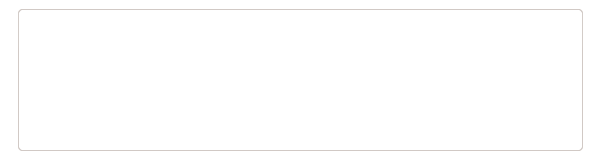
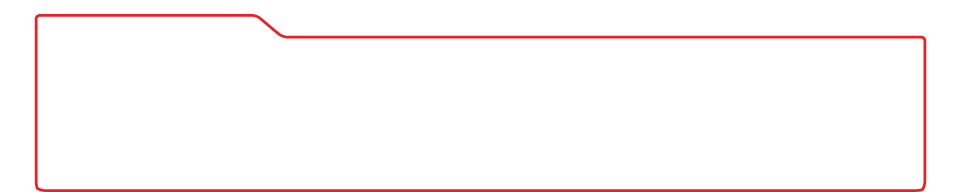
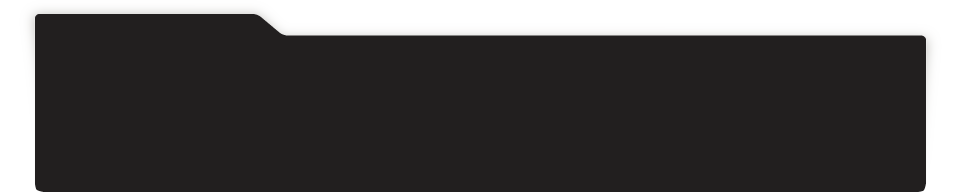
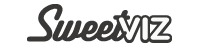
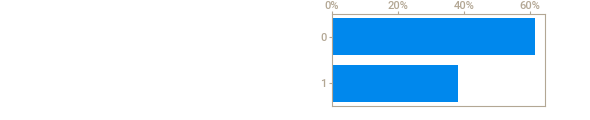
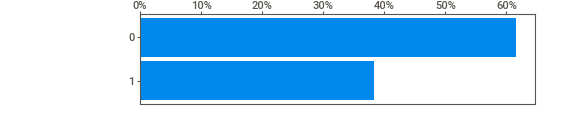
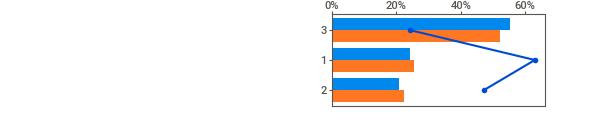
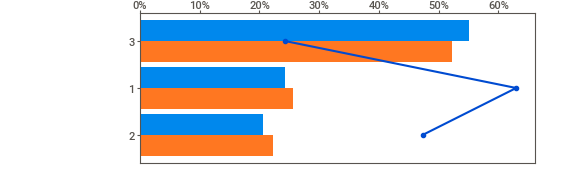
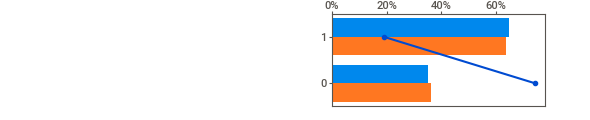
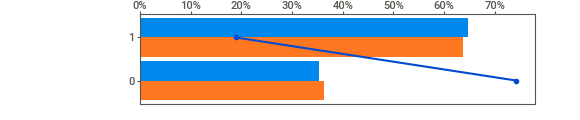
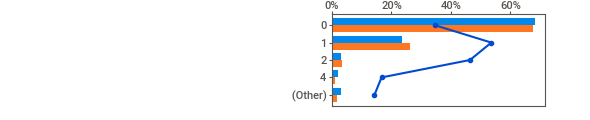
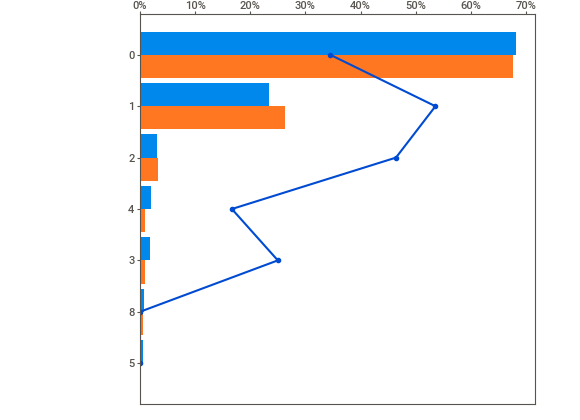
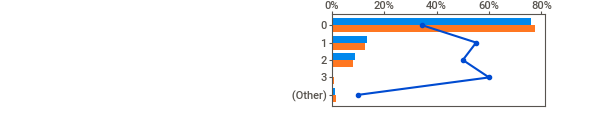
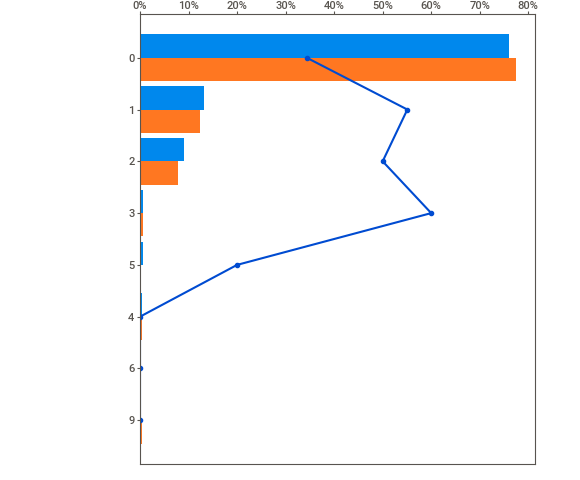
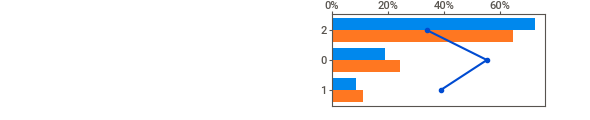
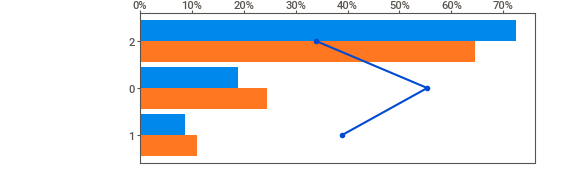
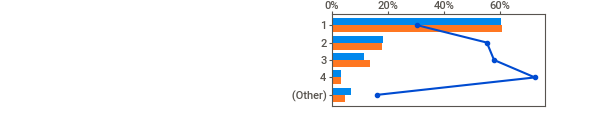
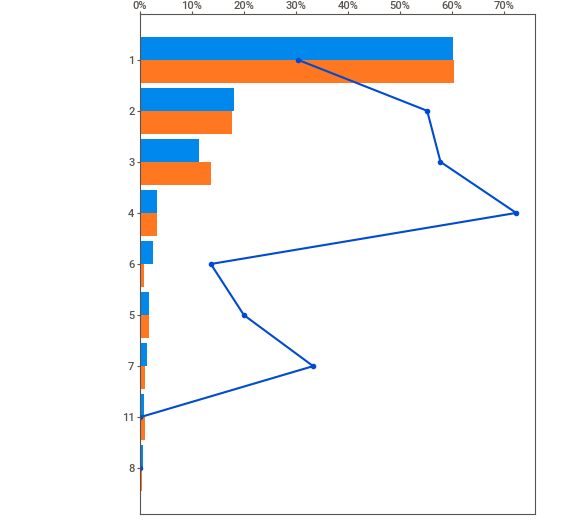
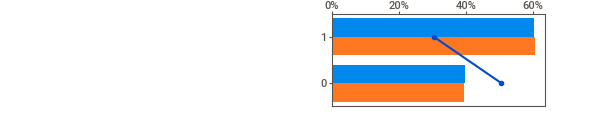
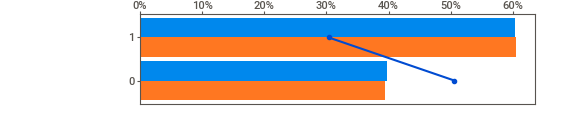
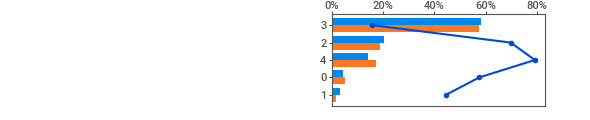
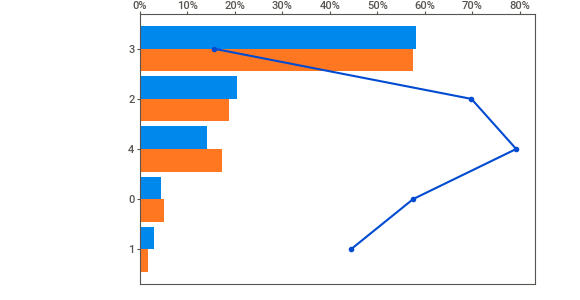
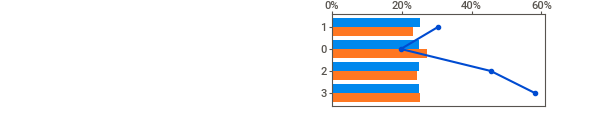
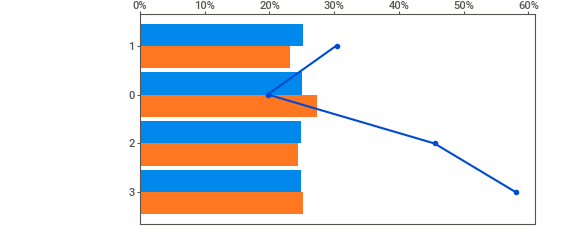
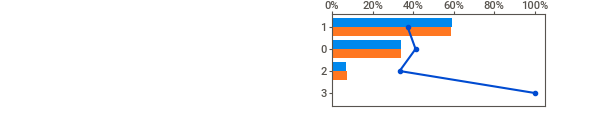
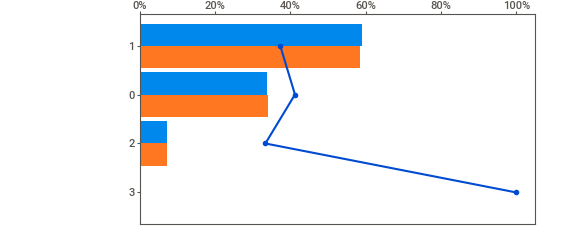
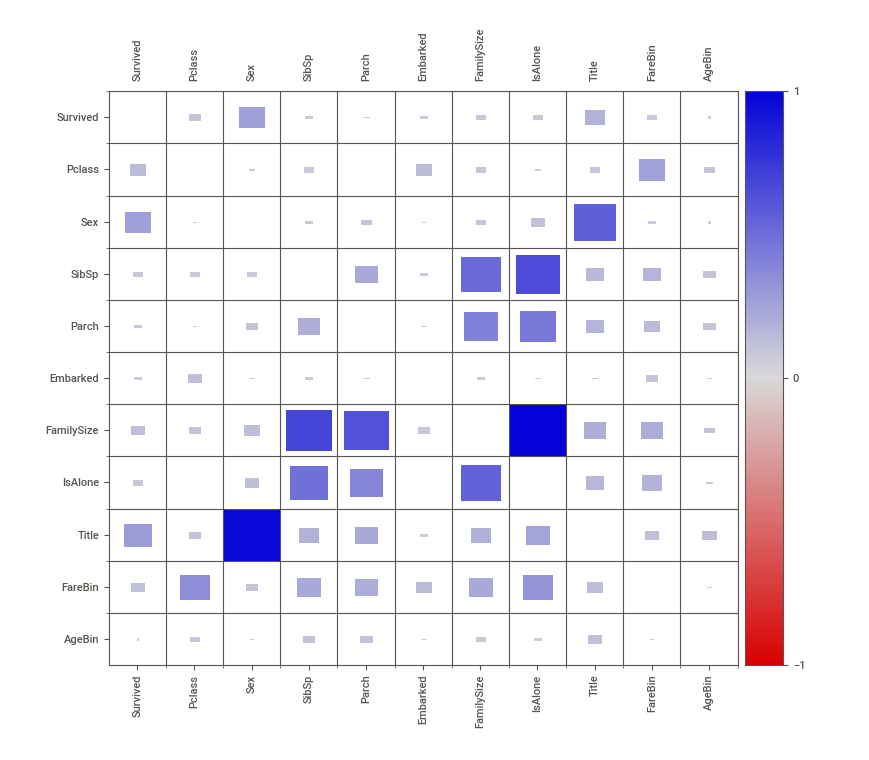
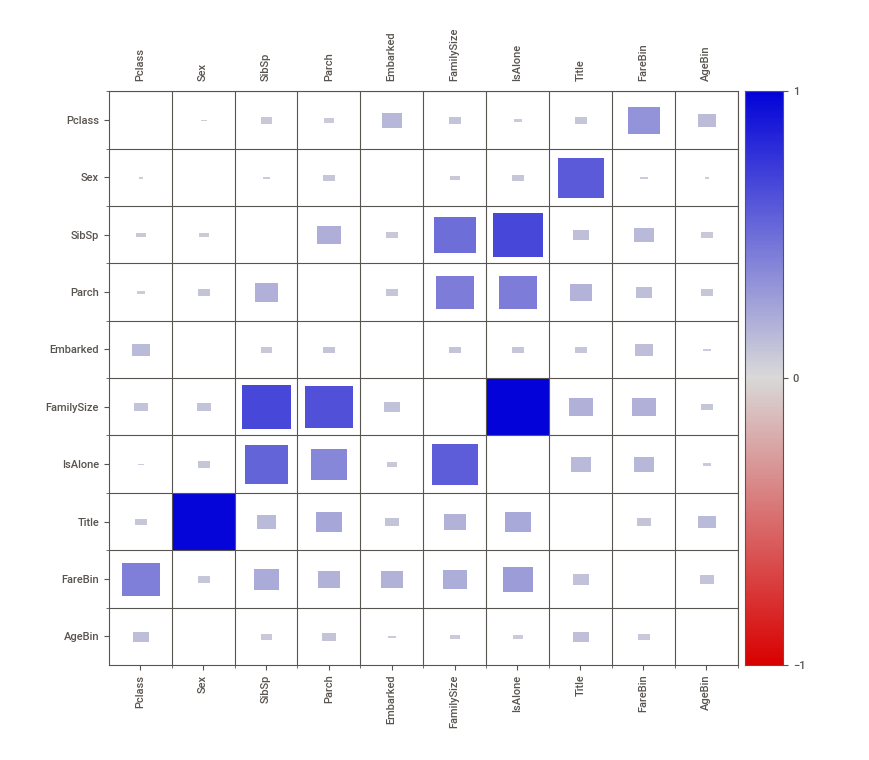

In [12]:
report = sv.compare([train_data, "Train"], [test_data, "Test"], target_feat="Survived")
report.show_notebook()

In [13]:
y = train_data.pop("Survived")
X = train_data

## 2  Lazypredict Baseline

In [14]:
!pip install lazypredict==0.2.9
clear_output()

In [15]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

def lazy_predict(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    return models, predictions

lazy_predict(X, y)[0][:10]

100%|██████████| 29/29 [00:01<00:00, 22.74it/s]


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                    
LGBMClassifier              0.85               0.84     0.84      0.85   
XGBClassifier               0.83               0.82     0.82      0.83   
RandomForestClassifier      0.83               0.82     0.82      0.83   
NuSVC                       0.83               0.82     0.82      0.83   
ExtraTreeClassifier         0.82               0.81     0.81      0.82   
SVC                         0.82               0.81     0.81      0.82   
KNeighborsClassifier        0.82               0.81     0.81      0.82   
Perceptron                  0.79               0.81     0.81      0.79   
GaussianNB                  0.80               0.81     0.81      0.80   
BaggingClassifier           0.82               0.80     0.80      0.81   

                        Time Taken  
Model                               
LGBMClassifier                0.07  
XGBClassifier                 0.07  
RandomForestClassifier        0.19  
NuSVC                         0.04  
ExtraTreeClassifier           0.02  
SVC                           0.03  
KNeighborsClassifier          0.02  
Perceptron                    0.02  
GaussianNB                    0.02  
BaggingClassifier             0.04

## 3  Hyperparameters

In [16]:
batch_size = 64
lr = 0.1
dropout = 0.3
hidden_size = 512

## 4 Pytorch Dataset Enclosing

In this step, we will get the `X` and `y` from the **dataframe's values** and put them into our custom but redundant (for learning purpose) `torch.utils.data.Dataset`.

After that, we split the `Dataset` into training and validation datasets, load them using `DataLoader` with the contrived `collate_fn` function (for learning purpose again).

In [17]:
X_train = X.values
y_train = y.values
print("train_set shape:", X_train.shape)

X_test = test_data.values
print("test_set shape:", X_test.shape)

feature_size = X_train.shape[-1]
target_size = 2

train_set shape: (891, 10)
test_set shape: (418, 10)


In [18]:
# Same as torch.utils.data.TensorDataset
class MyTensorDataset(Dataset):
    def __init__(self, X, y=None):
        if y is None:
            self.data = X
        else:
            self.data = list(zip(X, y))
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

In [19]:
train_dataset = MyTensorDataset(X_train, y_train)
test_dataset = MyTensorDataset(X_test)

train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])


def contrived_fn(batch_data):
    """
    Simulate the behavior of the default collate_fn.
    The return values must be tensor type.
    """
    tensor_X = []
    tensor_y = []
    for x, y in batch_data:
        tensor_X.append(x)
        tensor_y.append(y)
    
    return torch.FloatTensor(tensor_X), torch.LongTensor(tensor_y)

# train and val dataloader are moving to ray.tune
train_loader = DataLoader(train_set, batch_size, True, num_workers=4, collate_fn=contrived_fn)
val_loader = DataLoader(val_set, batch_size, num_workers=4, collate_fn=contrived_fn)
test_loader = DataLoader(test_dataset, batch_size, num_workers=4)

## 5 Network

In [20]:
class Net(nn.Module):
    def __init__(self, feature_size, target_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(feature_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, target_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [21]:
model = Net(feature_size=feature_size, target_size=target_size)
model

Net(
  (fc1): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

## 6 Train

### 6.1 Train Functions

In [22]:
def run_step(model, opt, dev, criterion, batch_X, batch_y, training=True):
    batch_X = batch_X.to(dev)
    batch_y = batch_y.to(dev)

    batch_pred = model(batch_X)
    loss = criterion(batch_pred, batch_y)
    acc = (batch_pred.max(1)[1] == batch_y).sum().item()

    if training:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return batch_pred, loss, acc


def run_epoch(model, opt, dev, criterion, data_loader, training=True):
    if training:
        model.train()
    else:
        model.eval()
    
    epoch_loss = 0
    epoch_acc = 0

    for batch_X, batch_y in tqdm(data_loader):
        _, step_loss, step_acc = run_step(model, opt, dev, criterion, batch_X, batch_y, training)
        epoch_loss += step_loss
        epoch_acc += step_acc

    epoch_loss = (epoch_loss / len(data_loader)).item()
    epoch_acc = (epoch_acc / len(data_loader.dataset)) * 100
    return epoch_loss, epoch_acc

### 6.2 Define optimizer, loss, device

In [23]:
opt  = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
dev  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 6.3 Train with validation

In [24]:
ckpt_dir.mkdir(exist_ok=True, parents=True)
log_dir.mkdir(exist_ok=True, parents=True)

In [25]:
epoch = 50
model.to(dev)

train_loss = []
train_acc = []
eval_loss = []
eval_acc = []

min_loss = np.inf

for i in range(epoch):

    epoch_train_loss, epoch_train_acc = run_epoch(model, opt, dev, criterion, train_loader, training=True)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)

    with torch.no_grad():
        epoch_eval_loss, epoch_eval_acc = run_epoch(model, opt, dev, criterion, val_loader, training=False)
        eval_loss.append(epoch_eval_loss)
        eval_acc.append(epoch_eval_acc)

    if epoch_eval_loss < min_loss:
        min_loss = epoch_eval_loss
        torch.save(model.state_dict(), ckpt_dir / "model.pt")

    print(f"Epoch {i+1}: \ntrain=loss: {epoch_train_loss}, acc: {epoch_train_acc}\nvalidation=loss: {epoch_eval_loss}, acc: {epoch_eval_acc}")

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1: 
train=loss: 3.3810815811157227, acc: 53.93258426966292
validation=loss: 3.9557857513427734, acc: 59.217877094972074


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2: 
train=loss: 0.9750485420227051, acc: 69.80337078651685
validation=loss: 0.6378166675567627, acc: 72.06703910614524


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3: 
train=loss: 0.6676830649375916, acc: 69.80337078651685
validation=loss: 0.6124970316886902, acc: 70.39106145251397


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4: 
train=loss: 0.4996621906757355, acc: 74.85955056179775
validation=loss: 0.4705062210559845, acc: 79.3296089385475


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5: 
train=loss: 0.4966468811035156, acc: 75.42134831460675
validation=loss: 0.4976603090763092, acc: 77.6536312849162


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6: 
train=loss: 0.49099409580230713, acc: 78.51123595505618
validation=loss: 0.5754306316375732, acc: 74.30167597765363


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7: 
train=loss: 0.4910525381565094, acc: 76.40449438202246
validation=loss: 0.4983411729335785, acc: 75.97765363128491


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8: 
train=loss: 0.47649940848350525, acc: 79.07303370786516
validation=loss: 0.4453698694705963, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9: 
train=loss: 0.45669975876808167, acc: 80.47752808988764
validation=loss: 0.4662967622280121, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10: 
train=loss: 0.4380991458892822, acc: 80.33707865168539
validation=loss: 0.5939223766326904, acc: 74.86033519553072


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11: 
train=loss: 0.4767019748687744, acc: 79.07303370786516
validation=loss: 0.45090779662132263, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12: 
train=loss: 0.4161684513092041, acc: 81.17977528089888
validation=loss: 0.4916176497936249, acc: 78.77094972067039


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13: 
train=loss: 0.4413336217403412, acc: 80.75842696629213
validation=loss: 0.5732909440994263, acc: 78.77094972067039


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14: 
train=loss: 0.4400857388973236, acc: 79.7752808988764
validation=loss: 0.6407744288444519, acc: 73.74301675977654


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15: 
train=loss: 0.47255340218544006, acc: 80.89887640449437
validation=loss: 0.8476211428642273, acc: 55.3072625698324


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16: 
train=loss: 0.4312892258167267, acc: 78.93258426966293
validation=loss: 0.4976853132247925, acc: 76.53631284916202


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17: 
train=loss: 0.40977153182029724, acc: 80.19662921348315
validation=loss: 0.4563116133213043, acc: 78.2122905027933


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18: 
train=loss: 0.39463579654693604, acc: 82.4438202247191
validation=loss: 0.4608343839645386, acc: 81.56424581005587


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19: 
train=loss: 0.41960588097572327, acc: 81.46067415730337
validation=loss: 0.49726709723472595, acc: 75.41899441340783


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20: 
train=loss: 0.44856539368629456, acc: 81.46067415730337
validation=loss: 0.6419309973716736, acc: 70.39106145251397


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21: 
train=loss: 0.4568599462509155, acc: 78.93258426966293
validation=loss: 0.5200000405311584, acc: 78.77094972067039


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22: 
train=loss: 0.43125584721565247, acc: 81.17977528089888
validation=loss: 0.4708132743835449, acc: 78.2122905027933


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23: 
train=loss: 0.40000686049461365, acc: 82.30337078651685
validation=loss: 0.4493219554424286, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24: 
train=loss: 0.41486015915870667, acc: 82.4438202247191
validation=loss: 0.44604623317718506, acc: 81.56424581005587


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25: 
train=loss: 0.427289754152298, acc: 82.16292134831461
validation=loss: 0.5325696468353271, acc: 74.30167597765363


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26: 
train=loss: 0.4011593163013458, acc: 82.4438202247191
validation=loss: 0.4692934453487396, acc: 77.09497206703911


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27: 
train=loss: 0.4143331050872803, acc: 82.02247191011236
validation=loss: 0.4745302200317383, acc: 75.41899441340783


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28: 
train=loss: 0.3962712585926056, acc: 81.32022471910112
validation=loss: 0.47429779171943665, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29: 
train=loss: 0.4018677771091461, acc: 83.14606741573034
validation=loss: 0.4863309860229492, acc: 77.6536312849162


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30: 
train=loss: 0.41859447956085205, acc: 79.91573033707866
validation=loss: 0.4615655243396759, acc: 80.44692737430168


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31: 
train=loss: 0.402532696723938, acc: 83.42696629213484
validation=loss: 0.451335072517395, acc: 79.3296089385475


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32: 
train=loss: 0.39700254797935486, acc: 82.02247191011236
validation=loss: 0.47960996627807617, acc: 77.6536312849162


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33: 
train=loss: 0.4233635663986206, acc: 80.89887640449437
validation=loss: 0.574918270111084, acc: 70.94972067039106


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34: 
train=loss: 0.44354677200317383, acc: 82.4438202247191
validation=loss: 0.7416264414787292, acc: 70.39106145251397


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35: 
train=loss: 0.4712334871292114, acc: 81.03932584269663
validation=loss: 0.511074423789978, acc: 79.88826815642457


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36: 
train=loss: 0.39841631054878235, acc: 82.7247191011236
validation=loss: 0.4795341491699219, acc: 78.77094972067039


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37: 
train=loss: 0.4353773593902588, acc: 82.02247191011236
validation=loss: 0.7027802467346191, acc: 73.18435754189943


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38: 
train=loss: 0.42976388335227966, acc: 81.60112359550563
validation=loss: 0.48906922340393066, acc: 76.53631284916202


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39: 
train=loss: 0.3864593207836151, acc: 82.86516853932584
validation=loss: 0.47125840187072754, acc: 77.09497206703911


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40: 
train=loss: 0.3873019218444824, acc: 83.14606741573034
validation=loss: 0.4397081434726715, acc: 82.68156424581005


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41: 
train=loss: 0.39369288086891174, acc: 82.86516853932584
validation=loss: 0.4570678174495697, acc: 81.56424581005587


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42: 
train=loss: 0.4095900058746338, acc: 82.7247191011236
validation=loss: 0.5374857783317566, acc: 77.6536312849162


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43: 
train=loss: 0.420866996049881, acc: 81.8820224719101
validation=loss: 0.4380991458892822, acc: 82.12290502793296


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44: 
train=loss: 0.41430357098579407, acc: 83.56741573033707
validation=loss: 0.4815463125705719, acc: 80.44692737430168


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45: 
train=loss: 0.4164273738861084, acc: 83.70786516853933
validation=loss: 0.5235990285873413, acc: 77.09497206703911


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46: 
train=loss: 0.399058073759079, acc: 82.16292134831461
validation=loss: 0.43980708718299866, acc: 83.24022346368714


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47: 
train=loss: 0.3899749517440796, acc: 82.86516853932584
validation=loss: 0.44227632880210876, acc: 82.68156424581005


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48: 
train=loss: 0.38168463110923767, acc: 82.86516853932584
validation=loss: 0.4360830783843994, acc: 82.68156424581005


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49: 
train=loss: 0.3868829309940338, acc: 82.16292134831461
validation=loss: 0.45429834723472595, acc: 81.00558659217877


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50: 
train=loss: 0.39088284969329834, acc: 83.42696629213484
validation=loss: 0.47549474239349365, acc: 80.44692737430168


## 7 Predict

In [26]:
model.load_state_dict(torch.load(ckpt_dir / "model.pt"))
model.eval()

Net(
  (fc1): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [27]:
result = []

with torch.no_grad():
    for X_test_batch in test_loader:
        X_test_batch = X_test_batch.to(dev)
        pred = model(X_test_batch.float())
        pred = pred.max(1)[1]
        result.extend(pred.tolist())

submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': result})

In [28]:
!pip install --upgrade pandas
clear_output()

In [29]:
submission_dir.mkdir(exist_ok=True, parents=True)
submission.to_csv(submission_dir / "torch_submission.csv", index=False)
submission

PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]

# 😸 Pytorch Lightning

* [PYTORCH LIGHTNING DOCUMENTATION](https://pytorch-lightning.readthedocs.io/en/stable/)
* [LIGHTNING IN 2 STEPS](https://pytorch-lightning.readthedocs.io/en/stable/starter/new-project.html)
* [LIGHTNING STYLE GUIDE](https://pytorch-lightning.readthedocs.io/en/stable/starter/style_guide.html)

We're going to use [Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) as our new framework to minimize the boilerplate code of our original Pytorch code above.


In [30]:
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
import pytorch_lightning as pl
clear_output()

## 1 Data Processing → LightningDataModules

https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html

A datamodule encapsulates the five steps involved in data processing in PyTorch:

1. Download / tokenize / process.
2. Clean and (maybe) save to disk.
3. Load inside Dataset.
4. Apply transforms (rotate, tokenize, etc…).
5. Wrap inside a DataLoader.

In [31]:
from torch.utils.data import TensorDataset

class TitanicDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size):
        super().__init__()
        self.batch_size = batch_size
        self.data_dir = data_dir


    def prepare_data(self):
        """
        Download datasets here. Not to assign variables here.
        ie: `prepare_data` is called from a single GPU. Do not use it to assign state (self.x = y).
        """


    def setup(self, stage=None):
        if stage == "fit":
            full_dataset = pd.read_csv(self.data_dir / "train.csv")
            full_dataset = self._data_preprocess(full_dataset)

            y = full_dataset.pop("Survived")
            X = full_dataset
            full_dataset = TensorDataset(torch.Tensor(X.values), torch.Tensor(y.values).long())

            train_size = int(len(full_dataset) * 0.8)
            val_size = len(full_dataset) - train_size
            self.train_set, self.val_set = random_split(full_dataset, [train_size, val_size])

        if stage == "test":
            test_dataset = pd.read_csv(self.data_dir / "test.csv")
            self.test_ids = test_dataset["PassengerId"]

            test_dataset = self._data_preprocess(test_dataset)
            self.test_set = TensorDataset(torch.Tensor(test_dataset.values))
            

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, shuffle=True, num_workers=8, pin_memory=True)


    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size, shuffle=False, num_workers=8, pin_memory=True)
    

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, shuffle=False, num_workers=8, pin_memory=True)


    def _data_preprocess(self, pd_dataset):
        pd_dataset["Age"].fillna(pd_dataset["Age"].median(), inplace=True)
        pd_dataset["Embarked"].fillna(pd_dataset["Embarked"].mode()[0], inplace=True)
        pd_dataset["Fare"].fillna(pd_dataset["Fare"].median(), inplace = True)
        # Data Cleaning
        drop_column = ['PassengerId', 'Cabin', 'Ticket']
        pd_dataset.drop(drop_column, axis=1, inplace=True)
        # Data Creating (Feature Engineering)
        pd_dataset['FamilySize'] = pd_dataset['SibSp'] + pd_dataset['Parch'] + 1
        pd_dataset['IsAlone'] = 1  #initialize to 1 = is alone
        pd_dataset['IsAlone'].loc[pd_dataset['FamilySize'] > 1] = 0  # now update to no if family size is greater than 1
        pd_dataset['Title'] = pd_dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        title_counts = pd_dataset['Title'].value_counts() < 10
        pd_dataset["Title"] = pd_dataset["Title"].apply(lambda x: "Misc" if title_counts.loc[x] == True else x)
        ## Divide the `Fare` into 4 intervals with similar quantities.
        pd_dataset['FareBin'] = pd.qcut(pd_dataset['Fare'], 4, labels=False)
        ## Divide the `Age` into 4 discrete intervals according to its value.
        pd_dataset['AgeBin'] = pd.cut(pd_dataset['Age'], [0, 25, 50, 75, 100], labels=False)
        ## Drop these columns since we have these features in the discrete version.
        pd_dataset.drop(columns=["Name", "Age", "Fare"], inplace=True)

        label_encoder = LabelEncoder()
        pd_dataset["Sex"] = label_encoder.fit_transform(pd_dataset["Sex"])
        pd_dataset["Title"] = label_encoder.fit_transform(pd_dataset["Title"])
        pd_dataset["Embarked"] = label_encoder.fit_transform(pd_dataset["Embarked"])

        return pd_dataset

In [32]:
dm = TitanicDataModule(data_dir, 64)

# Test whether the data module works by setting it manually.
dm.setup("fit")
first_batch, *_ = dm.train_dataloader()
print(first_batch[0].shape)

dm.setup("test")
first_batch, *_ = dm.test_dataloader()
print(first_batch[0].shape)

torch.Size([64, 10])
torch.Size([64, 10])


## 2 Train, Validate, Test → All in LightningModule

https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html

A LightningModule organizes your PyTorch code into 5 sections.

1. Computations (init).
2. Train loop (training_step)
3. Validation loop (validation_step)
4. Test loop (test_step)
5. Optimizers (configure_optimizers)

The LightningModule has many convenience methods, but the core ones you need to know about are:

| Name                 | Description                                          |
| -------------------- | ---------------------------------------------------- |
| init                 | Define computations here                             |
| forward              | Use for inference only (separate from training_step) |
| training_step        | the full training loop                               |
| validation_step      | the full validation loop                             |
| test_step            | the full test loop                                   |
| configure_optimizers | define optimizers and LR schedulers                  |

The lightning does under the hood is:

``` python
# put model in train mode
model.train()
torch.set_grad_enabled(True)

losses = []
for batch in model.train_dataloader:
    # calls hooks like this one
    model.on_train_batch_start(batch)

    # train step
    loss = model.training_step(batch)

    # backward
    loss.backward()

    # apply and clear grads
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss)

    if validate_at_some_point:
        # disable grads + batchnorm + dropout
        torch.set_grad_enabled(False)
        model.eval()

        # ----------------- VAL LOOP ---------------
        for val_batch in model.val_dataloader:
            val_out = model.validation_step(val_batch)
        # ----------------- VAL LOOP ---------------

        # enable grads + batchnorm + dropout
        torch.set_grad_enabled(True)
        model.train()

training_epoch_end(losses)
```

In [33]:
class TitanicModel(pl.LightningModule):
    def __init__(self, feature_size, hidden_size, target_size, dropout, lr):
        # super(TitanicModel, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(feature_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, target_size)
        self.dropout = nn.Dropout(dropout)
        self.lr = lr
        self.save_hyperparameters()


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


    def training_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger.
        # detail: https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#log
        self.log_dict({"train_loss": loss, "train_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # must return loss for continued training (ie: grad and step)
        return {"loss": loss, "pred": pred}


    def training_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each training_step, override training_epoch_end yourself.
        """


    def validation_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        self.log_dict({"val_loss": loss, "val_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # return when you want to do something at validation_epoch_end()
        # return pred
    

    def validation_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each validation_step, override validation_epoch_end.
        """        


    def test_step(self, batch, batch_idx):
        X = batch[0]
        pred = self(X)
        return pred

    
    def test_epoch_end(self, output):
        pred = torch.cat([batch.max(1)[1] for batch in output])
        self.test_result = pred.detach()

    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)


    def accuracy(self, batch_pred, batch_y):
        correct = (batch_pred.max(1)[1] == batch_y).sum().detach()
        accuracy = correct / len(batch_y)
        return torch.tensor(accuracy)


In [34]:
model = TitanicModel(10, 512, 2, 0.3, 0.1)

## 3 Let Trainer does everything

https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html

Now we have both `datamodule` and `lightningmodule`, we can start training, validating, visualizing, and testing. We only need to create an instance of `Trainer`, pass `lightningmodule`, `datamodule`, some parameters, and useful callbacks, then we're ready to train.

Here are the purposes of parameters which I define below:

- `default_root_dir` will be the path for **tensorboard logs** and **checkpoints**.
- `weights_save_path` will specifiy the path for **checkpoints**, and the `default_root_dir` remains the path for **tensorboard logs**.
- `fast_dev_run` will run 1 epoch for debugging; you can also set `n` epochs instead of `bool`.

> * [default_root_dir](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#default-root-dir)
> * [weights_save_path](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#weights-save-path)

We can use many **callbacks** in `Trainer`, such as `ModelCheckpoint`, `EarlyStopping`, etc. Please check the documentation of checkpoint below.

> * [Model Checkpoint](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.callbacks.model_checkpoint.html#model-checkpointing)
> * [Callbacks](https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html)

For saving checkpoints, we use `self.save_hyperparameters()` in lightningmodule's `__init__()` function to save hyperparameters in `lightningmodule.hparams`. 

For loading checkpoints, `model.load_from_checkpoint(checkpoint.best_model_path)` can help us load the best parameters and hyperparameters into the model.

> * [HYPERPARAMETERS](https://pytorch-lightning.readthedocs.io/en/stable/common/hyperparameters.html)
> * [Saving and loading weights](https://pytorch-lightning.readthedocs.io/en/stable/common/weights_loading.html)

In [35]:
# define model checkpoint
checkpoint = pl.callbacks.ModelCheckpoint(dirpath=ckpt_dir,  # path for saving checkpoints
                                          filename="{epoch}-{val_loss:.3f}",
                                          monitor="val_loss",
                                          mode="min")

In [36]:
trainer = pl.Trainer(fast_dev_run=False,
                     max_epochs=100,
                     default_root_dir=log_dir,  # path for saving logs
                     weights_save_path=ckpt_dir,  # path for saving checkpoints
                     callbacks=[checkpoint])

trainer.fit(model, dm)

Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

1

In [37]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs/

In [38]:
model.load_from_checkpoint(checkpoint.best_model_path)

TitanicModel(
  (fc1): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [39]:
trainer.test(model, datamodule=dm)
submission = pd.DataFrame({'PassengerId': dm.test_ids, 'Survived': model.test_result})
submission.to_csv(submission_dir / "torch_lightning_submission.csv", index=False)
submission

Testing: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------


PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]

# 😽 Ray Tune

**Concept of Ray Tune**:

* Define **search space** (range of hyperparameters) and **sample methods**
  * [Search Space](https://docs.ray.io/en/master/tune/api_docs/search_space.html)
* Define **schedulers** for EarlyStopping or PBT (Population-based training)
  * You can further optimize your hyperparameters by using **search algorithms**
* Run well-defined **trainables** (training functions in your epochs) on separate **TRIALS**
* Communicate the **performance of each trial** back to Tune by calling **REPORT**
* Evaluate the model with the returned **Analysis object**

Reference: [KEY CONCEPTS](https://docs.ray.io/en/master/tune/key-concepts.html)

---

**Integration of Lightning and Ray Tune**:

* Define a `config` (**search space**) dict, and plug it into `LightningModules`
* Define a `Scheduler` to stop unuseful trials early
* Define a `TuneReportCallback` for reporting the trials results to Tune
* Define a Trainable function with `constant parameters`, `trainer`, `model`, and `datamodule`
* Tuning, Analyzing, Predicting 

Reference: [RAY WITH LIGHTNING](https://docs.ray.io/en/master/tune/tutorials/tune-pytorch-lightning.html)

> ❗❗❗
>
> I found that when you integrate `lightning` with `ray tune`, you must use `model.load_state_dict()` instead of `model.load_from_checkpoint()` to really get the trained weights. 😥

In [40]:
!pip install ray[tune]
clear_output()

In [41]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback

## 1 Define Search space and config 

The first thing is to reconstruct the `LightningDataModule` and `LightningModule`; We have to re-define the arguments of two classes and feed the hyperparameters configs into them. 

We can learn how to define search space from [Search Space API](https://docs.ray.io/en/master/tune/api_docs/search_space.html)

For example:

num_samples=10 repeats the 3x3 grid search 10 times, for a total of 90 trials, each with randomly sampled values of alpha and beta.

``` python
tune.run(
     my_trainable,
     name="my_trainable",
     # num_samples will repeat the entire config 10 times.
     num_samples=10
     config={
         # ``sample_from`` creates a generator to call the lambda once per trial.
         "alpha": tune.sample_from(lambda spec: np.random.uniform(100)),
         # ``sample_from`` also supports "conditional search spaces"
         "beta": tune.sample_from(lambda spec: spec.config.alpha * np.random.normal()),
         "nn_layers": [
             # tune.grid_search will make it so that all values are evaluated.
             tune.grid_search([16, 64, 256]),
             tune.grid_search([16, 64, 256]),
         ],
     },
 )
```

In [42]:
config = {
    "batch_size": tune.choice([64, 128, 256]),
    "hidden_size": tune.grid_search([128, 256, 512]),
    "dropout": tune.uniform(0.1, 0.3),
    "lr": tune.loguniform(0.01, 0.1),
}

In [43]:
from torch.utils.data import TensorDataset

class TitanicDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, config):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = config["batch_size"]


    def prepare_data(self):
        """
        Download datasets here. Not to assign variables here.
        ie: `prepare_data` is called from a single GPU. Do not use it to assign state (self.x = y).
        """


    def setup(self, stage=None):
        if stage == "fit":
            full_dataset = pd.read_csv(self.data_dir / "train.csv")
            full_dataset = self._data_preprocess(full_dataset)

            y = full_dataset.pop("Survived")
            X = full_dataset
            full_dataset = TensorDataset(torch.Tensor(X.values), torch.Tensor(y.values).long())

            train_size = int(len(full_dataset) * 0.7)
            val_size = len(full_dataset) - train_size
            self.train_set, self.val_set = random_split(full_dataset, [train_size, val_size])

        if stage == "test":
            test_dataset = pd.read_csv(self.data_dir / "test.csv")
            self.test_ids = test_dataset["PassengerId"]

            test_dataset = self._data_preprocess(test_dataset)
            self.test_set = TensorDataset(torch.Tensor(test_dataset.values))
            

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, shuffle=True, num_workers=8, pin_memory=True)


    def val_dataloader(self):
        return DataLoader(self.val_set, self.batch_size, shuffle=False, num_workers=8, pin_memory=True)
    

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, shuffle=False, num_workers=8, pin_memory=True)


    def _data_preprocess(self, pd_dataset):
        pd_dataset["Age"].fillna(pd_dataset["Age"].median(), inplace=True)
        pd_dataset["Embarked"].fillna(pd_dataset["Embarked"].mode()[0], inplace=True)
        pd_dataset["Fare"].fillna(pd_dataset["Fare"].median(), inplace = True)
        # Data Cleaning
        drop_column = ['PassengerId', 'Cabin', 'Ticket']
        pd_dataset.drop(drop_column, axis=1, inplace=True)
        # Data Creating (Feature Engineering)
        pd_dataset['FamilySize'] = pd_dataset['SibSp'] + pd_dataset['Parch'] + 1
        pd_dataset['IsAlone'] = 1  #initialize to 1 = is alone
        pd_dataset['IsAlone'].loc[pd_dataset['FamilySize'] > 1] = 0  # now update to no if family size is greater than 1
        pd_dataset['Title'] = pd_dataset["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        title_counts = pd_dataset['Title'].value_counts() < 10
        pd_dataset["Title"] = pd_dataset["Title"].apply(lambda x: "Misc" if title_counts.loc[x] == True else x)
        ## Divide the `Fare` into 4 intervals with similar quantities.
        pd_dataset['FareBin'] = pd.qcut(pd_dataset['Fare'], 4, labels=False)
        ## Divide the `Age` into 4 discrete intervals according to its value.
        pd_dataset['AgeBin'] = pd.cut(pd_dataset['Age'], [0, 25, 50, 75, 100], labels=False)
        ## Drop these columns since we have these features in the discrete version.
        pd_dataset.drop(columns=["Name", "Age", "Fare"], inplace=True)

        label_encoder = LabelEncoder()
        pd_dataset["Sex"] = label_encoder.fit_transform(pd_dataset["Sex"])
        pd_dataset["Title"] = label_encoder.fit_transform(pd_dataset["Title"])
        pd_dataset["Embarked"] = label_encoder.fit_transform(pd_dataset["Embarked"])

        return pd_dataset


class TitanicModel(pl.LightningModule):
    def __init__(self, feature_size, target_size, config):
        # super(TitanicModel, self).__init__()
        super().__init__()
        self.fc1 = nn.Linear(feature_size, config["hidden_size"])
        self.fc2 = nn.Linear(config["hidden_size"], target_size)
        self.dropout = nn.Dropout(config["dropout"])
        self.lr = config["lr"]
        self.save_hyperparameters()


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


    def training_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        # logs metrics for each training_step,
        # and the average across the epoch, to the progress bar and logger.
        # detail: https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html#log
        self.log_dict({"train_loss": loss, "train_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # must return loss for continued training (ie: grad and step)
        return {"loss": loss, "pred": pred}


    def training_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each training_step, override training_epoch_end yourself.
        """


    def validation_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        loss = F.cross_entropy(pred, y)
        acc = self.accuracy(pred, y)
        
        self.log_dict({"val_loss": loss, "val_acc": acc}, on_step=False, on_epoch=True, prog_bar=True)

        # return when you want to do something at validation_epoch_end()
        # return pred
    

    def validation_epoch_end(self, output):
        """
        If you need to do something with all the outputs of each validation_step, override validation_epoch_end.
        """        


    def test_step(self, batch, batch_idx):
        X = batch[0]
        pred = self(X)
        return pred

    
    def test_epoch_end(self, output):
        pred = torch.cat([batch.max(1)[1] for batch in output])
        self.test_result = pred.detach()

    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)


    def accuracy(self, batch_pred, batch_y):
        correct = (batch_pred.max(1)[1] == batch_y).sum().detach()
        accuracy = correct / len(batch_y)
        return torch.tensor(accuracy)

## 2 Define Schedulers

`Asynchronous Hyperband` scheduler can help us decide at each iteration which trials are likely to perform badly, and stops these trials.

- For more details: [Trial Schedulers](https://docs.ray.io/en/master/tune/api_docs/schedulers.html)

Another popular method for hyperparameter tuning, called `Population Based Training (PBT)`, instead perturbs hyperparameters during the training run.

- [Guide to Population Based Training (PBT)](https://docs.ray.io/en/master/tune/tutorials/tune-advanced-tutorial.html)

In [44]:
# Example of ASHA Scheduler
scheduler_asha = ASHAScheduler(
    max_t=100,
    grace_period=1,
    reduction_factor=2,
)

# Example of PBT
scheduler_pbt = PopulationBasedTraining(
        perturbation_interval=4,
        hyperparam_mutations={
            "batch_size": tune.grid_search([32, 64, 128]),
            "hidden_size": tune.choice([480, 510, 530]),
            "lr": tune.loguniform(1e-2, 1e-1),
})

## 3 Define Report Callbacks

`TuneReportCallback` or `TuneReportCheckpointCallback` is inherited from `pytorch_lightning.Callback`, it will report metrics from `LightningModule` back to Tune for finding the best hyperparameters.

In [45]:
from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback

tune_report_callback = TuneReportCheckpointCallback(
    metrics={
    "val_loss": "val_loss",
    "val_acc": "val_acc",
    },
    filename="ray_ckpt",
    on="validation_end",
)

## 4 Wrap the Trainer and Constants into a Trainable Function

We have to wrap the `model`, `datamodule`, and `trainer` into a trainable function and put them into the tunning process `tune.run()`.

I also put the **testing** code inside this function. If you pass the `trained_weights` into this function, it will load the `trained_weights` from the checkpoint into the `model`, and perform `trainer.test()` instead of `trainer.fit()`.


> ❗❗❗
>
> I found that when you integrate `lightning` with `ray tune`, you must use `model.load_state_dict()` instead of `model.load_from_checkpoint()` to really get the trained weights. 😥

In [46]:
def run_with_tune(config, data_dir=None, feature_size=10, target_size=2, epochs=50, gpus=0, trained_weights=None):
    model = TitanicModel(feature_size, target_size, config)
    dm = TitanicDataModule(data_dir, config)

    trainer = pl.Trainer(
        max_epochs=50,
        gpus=0,
        fast_dev_run=False,
        progress_bar_refresh_rate=0,
        weights_summary=None,
        default_root_dir=log_dir / "ray_logs",  # path for saving logs
        callbacks=[
            tune_report_callback,
        ],
    )

    if not trained_weights:
        trainer.fit(model, dm)

    else:
        model.load_state_dict(trained_weights)
        trainer.test(model, datamodule=dm)
        submission = pd.DataFrame({'PassengerId': dm.test_ids, 'Survived': model.test_result})

        ######### 
        # I check the real accuracy using the cheating answer which has 100% accuracy.
        # r = pd.read_csv(root_dir / "datasets" / "cheat.csv")["Survived"].values
        # s = submission["Survived"].values
        # print("acc: ", sum(s == r) / len(r))
        #########

        submission.to_csv(submission_dir / "ray_tune_submission.csv", index=False)
        print(submission)

## 5 Tuning

We can decide which parameters and metrics will be displayed on the command line by creating a `CLIReporter` explicitly and pass it into `tune.run(progress_reporter=)`.

Then we run the trainable function in the `tune.run()`. We wrap the trainable function in a `partial` function `tune.with_parameters()` which we can put the constant parameters into each trial.

In [47]:
!pip uninstall dataclasses -y
clear_output()

In [48]:
reporter = CLIReporter(
    parameter_columns=["batch_size", "hidden_size", "lr"],
    metric_columns=["val_loss", "val_acc", "training_iteration"]
)

result = tune.run(
    tune.with_parameters(
        run_with_tune,
        data_dir=data_dir,
        feature_size=10,
        target_size=2,
        epochs=50,
        gpus=0
        ),
    resources_per_trial={
        "cpu": 1,
        "gpu": 0,
    },
    local_dir=ckpt_dir / "ray_ckpt",  # path for saving checkpoints
    metric="val_loss",
    mode="min",
    config=config,
    num_samples=16,
    scheduler=scheduler_asha,
    progress_reporter=reporter,
    name="tune_titanic_asha",
)

2021-03-12 08:07:24,651	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265
2021-03-12 08:07:27,653	WARNING function_runner.py:541 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Memory usage on this node: 1.7/17.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 1/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 1/48 (1 RUNNING)
+--------------------+----------+-------+--------------+---------------+-----------+
| Trial name         | status   | loc   |   batch_size |   hidden_size |        lr |
|--------------------+----------+-------+--------------+---------------+-----------|
| _inner_fc692_00000 | RUNNING  |       |          256 |           128 | 0.0969533 |
+--------------------+----------+-------+--------------+---------------+-----------+




(pid=7249) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=7249) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7249) 
(pid=7249) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7249)   self._setitem_single_block(indexer, value, name)
(pid=7248) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=7248) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7248) 
(pid=7248) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7248)   self._setitem_single_block(indexer, value, name)
(pid=7250) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=7250) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7

Result for _inner_fc692_00003:
  date: 2021-03-12_08-07-37
  done: false
  experiment_id: cba0b330894f43189d673ca11e2beac6
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 7249
  should_checkpoint: true
  time_since_restore: 4.804003953933716
  time_this_iter_s: 4.804003953933716
  time_total_s: 4.804003953933716
  timestamp: 1615536457
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00003
  val_acc: 0.5858209133148193
  val_loss: 0.620085597038269
  
== Status ==
Memory usage on this node: 2.8/17.6 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.620085597038269
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00003 with val_loss=0.620085597038269 and parameters={'batch_size': 64, 'hidden_size': 128, 'lr': 0.022650303552435906}
Result logdir

(pid=7664) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=7664) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7664) 
(pid=7664) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7664)   self._setitem_single_block(indexer, value, name)
(pid=7665) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=7665) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7665) 
(pid=7665) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=7665)   self._setitem_single_block(indexer, value, name)
(pid=7659) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=7659) A value is trying to be set on a copy of a slice from a DataFrame
(pid=7

Result for _inner_fc692_00003:
  date: 2021-03-12_08-07-49
  done: false
  experiment_id: cba0b330894f43189d673ca11e2beac6
  hostname: 72eea028aa45
  iterations_since_restore: 14
  node_ip: 172.19.2.2
  pid: 7249
  should_checkpoint: true
  time_since_restore: 16.155638217926025
  time_this_iter_s: 0.7434325218200684
  time_total_s: 16.155638217926025
  timestamp: 1615536469
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: fc692_00003
  val_acc: 0.7276119589805603
  val_loss: 0.5218815803527832
  
== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: None | Iter 8.000: -0.549222469329834 | Iter 4.000: -0.5749694108963013 | Iter 2.000: -0.6185145974159241 | Iter 1.000: -1.0343567728996277
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00003 with val_loss=0.5218815803527832 and parameters={'batch_size': 64, 'hidden_s

(pid=7665) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=7665)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)
(pid=7664) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=7664)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)
(pid=7659) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(so

Result for _inner_fc692_00004:
  date: 2021-03-12_08-07-51
  done: false
  experiment_id: 31c0eb91bc5d47cbbb149cdc41a7c463
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 7665
  should_checkpoint: true
  time_since_restore: 5.728712320327759
  time_this_iter_s: 5.728712320327759
  time_total_s: 5.728712320327759
  timestamp: 1615536471
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00004
  val_acc: 0.6268656849861145
  val_loss: 0.6206759810447693
  
Result for _inner_fc692_00005:
  date: 2021-03-12_08-07-52
  done: true
  experiment_id: 316f8c2e6ad14b9289e5eb8b5e55fca7
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 7659
  should_checkpoint: true
  time_since_restore: 5.7646238803863525
  time_this_iter_s: 5.7646238803863525
  time_total_s: 5.7646238803863525
  timestamp: 1615536472
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00005
  val_acc: 0.6156716346740723
  

(pid=9041) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=9041) A value is trying to be set on a copy of a slice from a DataFrame
(pid=9041) 
(pid=9041) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=9041)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00004:
  date: 2021-03-12_08-08-02
  done: false
  experiment_id: 31c0eb91bc5d47cbbb149cdc41a7c463
  hostname: 72eea028aa45
  iterations_since_restore: 10
  node_ip: 172.19.2.2
  pid: 7665
  should_checkpoint: true
  time_since_restore: 16.09266424179077
  time_this_iter_s: 1.0644159317016602
  time_total_s: 16.09266424179077
  timestamp: 1615536482
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: fc692_00004
  val_acc: 0.746268630027771
  val_loss: 0.5014830827713013
  


(pid=9558) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=9558) A value is trying to be set on a copy of a slice from a DataFrame
(pid=9558) 
(pid=9558) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=9558)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 32.000: None | Iter 16.000: -0.5314385890960693 | Iter 8.000: -0.5298628807067871 | Iter 4.000: -0.5749694108963013 | Iter 2.000: -0.6038370728492737 | Iter 1.000: -0.731880784034729
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00003 with val_loss=0.49107030034065247 and parameters={'batch_size': 64, 'hidden_size': 128, 'lr': 0.022650303552435906}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 10/48 (1 PENDING, 4 RUNNING, 5 TERMINATED)
+--------------------+------------+-----------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc             |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+------------+---------

(pid=9041) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=9041)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00007:
  date: 2021-03-12_08-08-07
  done: false
  experiment_id: f7486e9ea584485d9ec876d87f0e6836
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 9041
  should_checkpoint: true
  time_since_restore: 6.688755035400391
  time_this_iter_s: 6.688755035400391
  time_total_s: 6.688755035400391
  timestamp: 1615536487
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00007
  val_acc: 0.7052238583564758
  val_loss: 0.5721545815467834
  
Result for _inner_fc692_00004:
  date: 2021-03-12_08-08-08
  done: false
  experiment_id: 31c0eb91bc5d47cbbb149cdc41a7c463
  hostname: 72eea028aa45
  iterations_since_restore: 16
  node_ip: 172.19.2.2
  pid: 7665
  should_checkpoint: true
  time_since_restore: 22.002920627593994
  time_this_iter_s: 0.9647669792175293
  time_total_s: 22.002920627593994
  timestamp: 1615536488
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: fc692_00004
  val_acc: 0.746268630027771


(pid=9558) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=9558)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00003:
  date: 2021-03-12_08-08-11
  done: false
  experiment_id: cba0b330894f43189d673ca11e2beac6
  hostname: 72eea028aa45
  iterations_since_restore: 37
  node_ip: 172.19.2.2
  pid: 7249
  should_checkpoint: true
  time_since_restore: 38.34878587722778
  time_this_iter_s: 1.1431682109832764
  time_total_s: 38.34878587722778
  timestamp: 1615536491
  timesteps_since_restore: 0
  training_iteration: 37
  trial_id: fc692_00003
  val_acc: 0.746268630027771
  val_loss: 0.4784415662288666
  
Result for _inner_fc692_00008:
  date: 2021-03-12_08-08-11
  done: false
  experiment_id: 8c6dd2f2daab4213b50a87a8873fcbf8
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 9558
  should_checkpoint: true
  time_since_restore: 7.4057440757751465
  time_this_iter_s: 7.4057440757751465
  time_total_s: 7.4057440757751465
  timestamp: 1615536491
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00008
  val_acc: 0.64552241563797
 

(pid=12023) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=12023) A value is trying to be set on a copy of a slice from a DataFrame
(pid=12023) 
(pid=12023) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=12023)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00003:
  date: 2021-03-12_08-08-24
  done: true
  experiment_id: cba0b330894f43189d673ca11e2beac6
  experiment_tag: 3_batch_size=64,dropout=0.29908,hidden_size=128,lr=0.02265
  hostname: 72eea028aa45
  iterations_since_restore: 50
  node_ip: 172.19.2.2
  pid: 7249
  should_checkpoint: true
  time_since_restore: 51.92318654060364
  time_this_iter_s: 0.9629266262054443
  time_total_s: 51.92318654060364
  timestamp: 1615536504
  timesteps_since_restore: 0
  training_iteration: 50
  trial_id: fc692_00003
  val_acc: 0.7388059496879578
  val_loss: 0.47685590386390686
  
Result for _inner_fc692_00007:
  date: 2021-03-12_08-08-25
  done: false
  experiment_id: f7486e9ea584485d9ec876d87f0e6836
  hostname: 72eea028aa45
  iterations_since_restore: 16
  node_ip: 172.19.2.2
  pid: 9041
  should_checkpoint: true
  time_since_restore: 24.263368129730225
  time_this_iter_s: 1.0433530807495117
  time_total_s: 24.263368129730225
  timestamp: 1615536505
  timesteps_since_restore: 

(pid=12023) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=12023)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00009:
  date: 2021-03-12_08-08-30
  done: true
  experiment_id: d16ec9e2cbfe4c0bb91b367b54db2a66
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 12023
  should_checkpoint: true
  time_since_restore: 7.8826799392700195
  time_this_iter_s: 7.8826799392700195
  time_total_s: 7.8826799392700195
  timestamp: 1615536510
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00009
  val_acc: 0.60447758436203
  val_loss: 0.6588910818099976
  
== Status ==
Memory usage on this node: 2.7/17.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 32.000: -0.4788116067647934 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5105032920837402 | Iter 4.000: -0.557401716709137 | Iter 2.000: -0.6033152639865875 | Iter 1.000: -0.6460835039615631
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.44575801491737366 and parameters={

(pid=13903) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=13903) A value is trying to be set on a copy of a slice from a DataFrame
(pid=13903) 
(pid=13903) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=13903)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00004:
  date: 2021-03-12_08-08-36
  done: false
  experiment_id: 31c0eb91bc5d47cbbb149cdc41a7c463
  hostname: 72eea028aa45
  iterations_since_restore: 41
  node_ip: 172.19.2.2
  pid: 7665
  should_checkpoint: true
  time_since_restore: 50.099117040634155
  time_this_iter_s: 0.9025187492370605
  time_total_s: 50.099117040634155
  timestamp: 1615536516
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: fc692_00004
  val_acc: 0.7761194109916687
  val_loss: 0.4659094512462616
  
== Status ==
Memory usage on this node: 2.5/17.6 GiB
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 32.000: -0.4788116067647934 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5105032920837402 | Iter 4.000: -0.557401716709137 | Iter 2.000: -0.6033152639865875 | Iter 1.000: -0.6460835039615631
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.44041842222213745 and paramete

(pid=14596) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=14596) A value is trying to be set on a copy of a slice from a DataFrame
(pid=14596) 
(pid=14596) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=14596)   self._setitem_single_block(indexer, value, name)
(pid=13903) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=13903)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00010:
  date: 2021-03-12_08-08-40
  done: true
  experiment_id: 06fcc1511cd9439985ccb39211a1b121
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 13903
  should_checkpoint: true
  time_since_restore: 6.605656623840332
  time_this_iter_s: 6.605656623840332
  time_total_s: 6.605656623840332
  timestamp: 1615536520
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00010
  val_acc: 0.6156716346740723
  val_loss: 0.7168894410133362
  
Result for _inner_fc692_00007:
  date: 2021-03-12_08-08-41
  done: false
  experiment_id: f7486e9ea584485d9ec876d87f0e6836
  hostname: 72eea028aa45
  iterations_since_restore: 31
  node_ip: 172.19.2.2
  pid: 9041
  should_checkpoint: true
  time_since_restore: 40.31807613372803
  time_this_iter_s: 1.1839303970336914
  time_total_s: 40.31807613372803
  timestamp: 1615536521
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: fc692_00007
  val_acc: 0.8097015023231506
 

(pid=14596) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=14596)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00011:
  date: 2021-03-12_08-08-45
  done: true
  experiment_id: 69e0492c588243dca211464edf62c162
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 14596
  should_checkpoint: true
  time_since_restore: 7.220726013183594
  time_this_iter_s: 7.220726013183594
  time_total_s: 7.220726013183594
  timestamp: 1615536525
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00011
  val_acc: 0.5783582329750061
  val_loss: 0.6597321629524231
  
Result for _inner_fc692_00007:
  date: 2021-03-12_08-08-46
  done: false
  experiment_id: f7486e9ea584485d9ec876d87f0e6836
  hostname: 72eea028aa45
  iterations_since_restore: 36
  node_ip: 172.19.2.2
  pid: 9041
  should_checkpoint: true
  time_since_restore: 45.734777212142944
  time_this_iter_s: 1.4659645557403564
  time_total_s: 45.734777212142944
  timestamp: 1615536526
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: fc692_00007
  val_acc: 0.753731369972229


(pid=15785) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=15785) A value is trying to be set on a copy of a slice from a DataFrame
(pid=15785) 
(pid=15785) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=15785)   self._setitem_single_block(indexer, value, name)
(pid=16383) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=16383) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16383) 
(pid=16383) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16383)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00007:
  date: 2021-03-12_08-08-52
  done: false
  experiment_id: f7486e9ea584485d9ec876d87f0e6836
  hostname: 72eea028aa45
  iterations_since_restore: 42
  node_ip: 172.19.2.2
  pid: 9041
  should_checkpoint: true
  time_since_restore: 51.0287868976593
  time_this_iter_s: 0.7993896007537842
  time_total_s: 51.0287868976593
  timestamp: 1615536532
  timesteps_since_restore: 0
  training_iteration: 42
  trial_id: fc692_00007
  val_acc: 0.8134328126907349
  val_loss: 0.43244829773902893
  
== Status ==
Memory usage on this node: 2.4/17.6 GiB
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5105032920837402 | Iter 4.000: -0.557401716709137 | Iter 2.000: -0.6033152639865875 | Iter 1.000: -0.6593116223812103
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.43244829773902893 and parameters

(pid=16480) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=16480) A value is trying to be set on a copy of a slice from a DataFrame
(pid=16480) 
(pid=16480) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=16480)   self._setitem_single_block(indexer, value, name)
(pid=15785) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=15785)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00012:
  date: 2021-03-12_08-08-53
  done: false
  experiment_id: 06b3899c4bba4112b3a1789d1aa8d59a
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 15785
  should_checkpoint: true
  time_since_restore: 5.182353496551514
  time_this_iter_s: 5.182353496551514
  time_total_s: 5.182353496551514
  timestamp: 1615536533
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00012
  val_acc: 0.6529850959777832
  val_loss: 0.6164380311965942
  
Result for _inner_fc692_00012:
  date: 2021-03-12_08-08-56
  done: true
  experiment_id: 06b3899c4bba4112b3a1789d1aa8d59a
  hostname: 72eea028aa45
  iterations_since_restore: 4
  node_ip: 172.19.2.2
  pid: 15785
  should_checkpoint: true
  time_since_restore: 7.803126335144043
  time_this_iter_s: 0.8754076957702637
  time_total_s: 7.803126335144043
  timestamp: 1615536536
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: fc692_00012
  val_acc: 0.6716417670249939
  

(pid=16383) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=16383)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00007:
  date: 2021-03-12_08-08-57
  done: false
  experiment_id: f7486e9ea584485d9ec876d87f0e6836
  hostname: 72eea028aa45
  iterations_since_restore: 48
  node_ip: 172.19.2.2
  pid: 9041
  should_checkpoint: true
  time_since_restore: 56.50480580329895
  time_this_iter_s: 1.132763147354126
  time_total_s: 56.50480580329895
  timestamp: 1615536537
  timesteps_since_restore: 0
  training_iteration: 48
  trial_id: fc692_00007
  val_acc: 0.7910447716712952
  val_loss: 0.44240155816078186
  
== Status ==
Memory usage on this node: 2.8/17.6 GiB
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5105032920837402 | Iter 4.000: -0.5749694108963013 | Iter 2.000: -0.6028897166252136 | Iter 1.000: -0.6588910818099976
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.44240155816078186 and paramet

(pid=16480) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=16480)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00013:
  date: 2021-03-12_08-08-58
  done: false
  experiment_id: c3e0431436f5443999639b16fa42f975
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 16383
  should_checkpoint: true
  time_since_restore: 6.406073331832886
  time_this_iter_s: 6.406073331832886
  time_total_s: 6.406073331832886
  timestamp: 1615536538
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00013
  val_acc: 0.60447758436203
  val_loss: 0.6392136216163635
  
Result for _inner_fc692_00014:
  date: 2021-03-12_08-08-59
  done: false
  experiment_id: d33401993c1343b1898847ced9fc5f75
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 16480
  should_checkpoint: true
  time_since_restore: 7.022941827774048
  time_this_iter_s: 7.022941827774048
  time_total_s: 7.022941827774048
  timestamp: 1615536539
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00014
  val_acc: 0.6604477763175964
  va

(pid=17446) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=17446) A value is trying to be set on a copy of a slice from a DataFrame
(pid=17446) 
(pid=17446) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=17446)   self._setitem_single_block(indexer, value, name)
(pid=17806) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=17806) A value is trying to be set on a copy of a slice from a DataFrame
(pid=17806) 
(pid=17806) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=17806)   self._setitem_single_block(indexer, value, name)
(pid=17885) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=17885) A value is trying to be set on a copy of a slice from a Data

Result for _inner_fc692_00015:
  date: 2021-03-12_08-09-10
  done: false
  experiment_id: 835c7dee16174a81aec2e2cbb8167ea6
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 17446
  should_checkpoint: true
  time_since_restore: 4.516249418258667
  time_this_iter_s: 4.516249418258667
  time_total_s: 4.516249418258667
  timestamp: 1615536550
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00015
  val_acc: 0.6305969953536987
  val_loss: 0.6179243922233582
  
== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5105032920837402 | Iter 4.000: -0.5749694108963013 | Iter 2.000: -0.604367733001709 | Iter 1.000: -0.6362447738647461
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.4720728099346161 and parameters=

(pid=17806) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=17806)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)
(pid=17885) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=17885)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)
(pid=17899) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tens

Result for _inner_fc692_00016:
  date: 2021-03-12_08-09-12
  done: true
  experiment_id: 51f620be9a924566ba40de35f5a99fdc
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 17806
  should_checkpoint: true
  time_since_restore: 5.273016452789307
  time_this_iter_s: 5.273016452789307
  time_total_s: 5.273016452789307
  timestamp: 1615536552
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00016
  val_acc: 0.6194030046463013
  val_loss: 0.6455310583114624
  
Result for _inner_fc692_00018:
  date: 2021-03-12_08-09-13
  done: false
  experiment_id: f00b435172d245bc9429712a29f84f11
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 17885
  should_checkpoint: true
  time_since_restore: 5.5148537158966064
  time_this_iter_s: 5.5148537158966064
  time_total_s: 5.5148537158966064
  timestamp: 1615536553
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00018
  val_acc: 0.7164179086685181


(pid=18464) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=18464) A value is trying to be set on a copy of a slice from a DataFrame
(pid=18464) 
(pid=18464) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=18464)   self._setitem_single_block(indexer, value, name)
(pid=18392) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=18392) A value is trying to be set on a copy of a slice from a DataFrame
(pid=18392) 
(pid=18392) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=18392)   self._setitem_single_block(indexer, value, name)
(pid=18463) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=18463) A value is trying to be set on a copy of a slice from a Data

Result for _inner_fc692_00020:
  date: 2021-03-12_08-09-25
  done: false
  experiment_id: 471e01ae594c45a0a1bd8bf8f2ae5bc4
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 18464
  should_checkpoint: true
  time_since_restore: 4.659607887268066
  time_this_iter_s: 4.659607887268066
  time_total_s: 4.659607887268066
  timestamp: 1615536565
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00020
  val_acc: 0.6679104566574097
  val_loss: 0.5859970450401306
  
== Status ==
Memory usage on this node: 2.8/17.6 GiB
Using AsyncHyperBand: num_stopped=16
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5273278653621674 | Iter 4.000: -0.5740105509757996 | Iter 2.000: -0.604367733001709 | Iter 1.000: -0.6378648579120636
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.4720728099346161 and parameters=

(pid=18784) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=18784)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00022:
  date: 2021-03-12_08-09-29
  done: true
  experiment_id: 2eb8128e973f4eef88f166bf2aa78c3f
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 18784
  should_checkpoint: true
  time_since_restore: 6.874157428741455
  time_this_iter_s: 6.874157428741455
  time_total_s: 6.874157428741455
  timestamp: 1615536569
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00022
  val_acc: 0.6604477763175964
  val_loss: 0.6420295238494873
  


(pid=19077) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=19077) A value is trying to be set on a copy of a slice from a DataFrame
(pid=19077) 
(pid=19077) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=19077)   self._setitem_single_block(indexer, value, name)
(pid=19127) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=19127) A value is trying to be set on a copy of a slice from a DataFrame
(pid=19127) 
(pid=19127) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=19127)   self._setitem_single_block(indexer, value, name)
(pid=19126) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=19126) A value is trying to be set on a copy of a slice from a Data

Result for _inner_fc692_00023:
  date: 2021-03-12_08-09-38
  done: false
  experiment_id: a8e6652d81184c60838a6cb73be48576
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 19077
  should_checkpoint: true
  time_since_restore: 4.880447149276733
  time_this_iter_s: 4.880447149276733
  time_total_s: 4.880447149276733
  timestamp: 1615536578
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00023
  val_acc: 0.6679104566574097
  val_loss: 0.6150678992271423
  
== Status ==
Memory usage on this node: 2.8/17.6 GiB
Using AsyncHyperBand: num_stopped=20
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5273278653621674 | Iter 4.000: -0.5740105509757996 | Iter 2.000: -0.6054113507270813 | Iter 1.000: -0.6378648579120636
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.4720728099346161 and parameters

(pid=19181) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19181)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00024:
  date: 2021-03-12_08-09-39
  done: false
  experiment_id: 7f35c6c4f4bd4d40ba6c3e1ddb466756
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 19126
  should_checkpoint: true
  time_since_restore: 5.080216884613037
  time_this_iter_s: 5.080216884613037
  time_total_s: 5.080216884613037
  timestamp: 1615536579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00024
  val_acc: 0.6529850959777832
  val_loss: 0.6238768100738525
  
Result for _inner_fc692_00025:
  date: 2021-03-12_08-09-39
  done: true
  experiment_id: 915fad2752ce4a5082cb86a6ee0bd87a
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 19127
  should_checkpoint: true
  time_since_restore: 5.49590539932251
  time_this_iter_s: 5.49590539932251
  time_total_s: 5.49590539932251
  timestamp: 1615536579
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00025
  val_acc: 0.6268656849861145
  val_

(pid=19698) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=19698) A value is trying to be set on a copy of a slice from a DataFrame
(pid=19698) 
(pid=19698) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=19698)   self._setitem_single_block(indexer, value, name)
(pid=20006) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=20006) A value is trying to be set on a copy of a slice from a DataFrame
(pid=20006) 
(pid=20006) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=20006)   self._setitem_single_block(indexer, value, name)
(pid=19980) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=19980) A value is trying to be set on a copy of a slice from a Data

Result for _inner_fc692_00027:
  date: 2021-03-12_08-09-53
  done: false
  experiment_id: e2c833664d5945eaa60c173a2fd41e8e
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 19698
  should_checkpoint: true
  time_since_restore: 4.9930641651153564
  time_this_iter_s: 4.9930641651153564
  time_total_s: 4.9930641651153564
  timestamp: 1615536593
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00027
  val_acc: 0.6567164063453674
  val_loss: 0.5846242308616638
  
== Status ==
Memory usage on this node: 2.5/17.6 GiB
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5441524386405945 | Iter 4.000: -0.5739938914775848 | Iter 2.000: -0.6048895418643951 | Iter 1.000: -0.6348960101604462
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.4720728099346161 and paramet

(pid=20378) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=20378) A value is trying to be set on a copy of a slice from a DataFrame
(pid=20378) 
(pid=20378) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=20378)   self._setitem_single_block(indexer, value, name)
(pid=20006) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=20006)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00027:
  date: 2021-03-12_08-09-54
  done: true
  experiment_id: e2c833664d5945eaa60c173a2fd41e8e
  hostname: 72eea028aa45
  iterations_since_restore: 2
  node_ip: 172.19.2.2
  pid: 19698
  should_checkpoint: true
  time_since_restore: 5.950495719909668
  time_this_iter_s: 0.9574315547943115
  time_total_s: 5.950495719909668
  timestamp: 1615536594
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: fc692_00027
  val_acc: 0.6567164063453674
  val_loss: 0.6532806158065796
  


(pid=19980) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=19980)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00029:
  date: 2021-03-12_08-09-55
  done: false
  experiment_id: 2c42164698e24352918f8576fc65d9cc
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 20006
  should_checkpoint: true
  time_since_restore: 5.462421178817749
  time_this_iter_s: 5.462421178817749
  time_total_s: 5.462421178817749
  timestamp: 1615536595
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00029
  val_acc: 0.6940298676490784
  val_loss: 0.5840703845024109
  
Result for _inner_fc692_00028:
  date: 2021-03-12_08-09-55
  done: true
  experiment_id: 14e534e959d04f5e9e627fe6909356b6
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 19980
  should_checkpoint: true
  time_since_restore: 5.42430853843689
  time_this_iter_s: 5.42430853843689
  time_total_s: 5.42430853843689
  timestamp: 1615536595
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00028
  val_acc: 0.6231343150138855
  val_

(pid=20378) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=20378)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00030:
  date: 2021-03-12_08-10-00
  done: false
  experiment_id: 31380d7c6ea2428d9aacd9d72cb0e67a
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 20378
  should_checkpoint: true
  time_since_restore: 6.9101338386535645
  time_this_iter_s: 6.9101338386535645
  time_total_s: 6.9101338386535645
  timestamp: 1615536600
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00030
  val_acc: 0.6753731369972229
  val_loss: 0.613044798374176
  
Result for _inner_fc692_00029:
  date: 2021-03-12_08-10-00
  done: false
  experiment_id: 2c42164698e24352918f8576fc65d9cc
  hostname: 72eea028aa45
  iterations_since_restore: 6
  node_ip: 172.19.2.2
  pid: 20006
  should_checkpoint: true
  time_since_restore: 10.98236870765686
  time_this_iter_s: 1.1730165481567383
  time_total_s: 10.98236870765686
  timestamp: 1615536600
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: fc692_00029
  val_acc: 0.7164179086685181

(pid=20587) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=20587) A value is trying to be set on a copy of a slice from a DataFrame
(pid=20587) 
(pid=20587) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=20587)   self._setitem_single_block(indexer, value, name)
(pid=20738) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=20738) A value is trying to be set on a copy of a slice from a DataFrame
(pid=20738) 
(pid=20738) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=20738)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5312553346157074 | Iter 4.000: -0.573615550994873 | Iter 2.000: -0.6054113507270813 | Iter 1.000: -0.6332759261131287
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.4720728099346161 and parameters={'batch_size': 64, 'hidden_size': 256, 'lr': 0.05313818834293614}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 35/48 (1 PENDING, 4 RUNNING, 30 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+----

(pid=20587) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=20587)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)
(pid=20738) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=20738)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00031:
  date: 2021-03-12_08-10-08
  done: false
  experiment_id: cd139fc9aca4421d855253eb47aed6aa
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 20587
  should_checkpoint: true
  time_since_restore: 6.74829626083374
  time_this_iter_s: 6.74829626083374
  time_total_s: 6.74829626083374
  timestamp: 1615536608
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00031
  val_acc: 0.6716417670249939
  val_loss: 0.6126397848129272
  


(pid=21172) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=21172) A value is trying to be set on a copy of a slice from a DataFrame
(pid=21172) 
(pid=21172) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=21172)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=27
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.5017057061195374 | Iter 8.000: -0.5312553346157074 | Iter 4.000: -0.573615550994873 | Iter 2.000: -0.6054113507270813 | Iter 1.000: -0.6309842467308044
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00007 with val_loss=0.4720728099346161 and parameters={'batch_size': 64, 'hidden_size': 256, 'lr': 0.05313818834293614}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 35/48 (1 PENDING, 4 RUNNING, 30 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+----

(pid=21172) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=21172)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00033:
  date: 2021-03-12_08-10-17
  done: false
  experiment_id: 89747830d2e1468ba6a19e38482c6b72
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 21172
  should_checkpoint: true
  time_since_restore: 7.869231700897217
  time_this_iter_s: 7.869231700897217
  time_total_s: 7.869231700897217
  timestamp: 1615536617
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00033
  val_acc: 0.6791045069694519
  val_loss: 0.6255907416343689
  
Result for _inner_fc692_00029:
  date: 2021-03-12_08-10-17
  done: false
  experiment_id: 2c42164698e24352918f8576fc65d9cc
  hostname: 72eea028aa45
  iterations_since_restore: 21
  node_ip: 172.19.2.2
  pid: 20006
  should_checkpoint: true
  time_since_restore: 27.419214725494385
  time_this_iter_s: 1.0454063415527344
  time_total_s: 27.419214725494385
  timestamp: 1615536617
  timesteps_since_restore: 0
  training_iteration: 21
  trial_id: fc692_00029
  val_acc: 0.74253731966018

(pid=22246) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=22246) A value is trying to be set on a copy of a slice from a DataFrame
(pid=22246) 
(pid=22246) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=22246)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00029:
  date: 2021-03-12_08-10-23
  done: false
  experiment_id: 2c42164698e24352918f8576fc65d9cc
  hostname: 72eea028aa45
  iterations_since_restore: 26
  node_ip: 172.19.2.2
  pid: 20006
  should_checkpoint: true
  time_since_restore: 33.299758434295654
  time_this_iter_s: 1.0171253681182861
  time_total_s: 33.299758434295654
  timestamp: 1615536623
  timesteps_since_restore: 0
  training_iteration: 26
  trial_id: fc692_00029
  val_acc: 0.746268630027771
  val_loss: 0.5041233897209167
  
== Status ==
Memory usage on this node: 2.5/17.6 GiB
Using AsyncHyperBand: num_stopped=29
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.500701829791069 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5739938914775848 | Iter 2.000: -0.6042200326919556 | Iter 1.000: -0.6271416544914246
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.45794621109962463 and parame

(pid=22246) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=22246)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00034:
  date: 2021-03-12_08-10-28
  done: true
  experiment_id: f65c743836a54802a4a5870bd39484ba
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 22246
  should_checkpoint: true
  time_since_restore: 7.217167854309082
  time_this_iter_s: 7.217167854309082
  time_total_s: 7.217167854309082
  timestamp: 1615536628
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00034
  val_acc: 0.6194030046463013
  val_loss: 1.31875479221344
  
Result for _inner_fc692_00029:
  date: 2021-03-12_08-10-28
  done: false
  experiment_id: 2c42164698e24352918f8576fc65d9cc
  hostname: 72eea028aa45
  iterations_since_restore: 31
  node_ip: 172.19.2.2
  pid: 20006
  should_checkpoint: true
  time_since_restore: 38.706608295440674
  time_this_iter_s: 1.0661652088165283
  time_total_s: 38.706608295440674
  timestamp: 1615536628
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: fc692_00029
  val_acc: 0.7425373196601868


(pid=23273) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=23273) A value is trying to be set on a copy of a slice from a DataFrame
(pid=23273) 
(pid=23273) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=23273)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00029:
  date: 2021-03-12_08-10-29
  done: true
  experiment_id: 2c42164698e24352918f8576fc65d9cc
  hostname: 72eea028aa45
  iterations_since_restore: 32
  node_ip: 172.19.2.2
  pid: 20006
  should_checkpoint: true
  time_since_restore: 39.9261429309845
  time_this_iter_s: 1.2195346355438232
  time_total_s: 39.9261429309845
  timestamp: 1615536629
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: fc692_00029
  val_acc: 0.7425373196601868
  val_loss: 0.4853086471557617
  
== Status ==
Memory usage on this node: 2.7/17.6 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 64.000: None | Iter 32.000: -0.4788116067647934 | Iter 16.000: -0.4996979534626007 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5739938914775848 | Iter 2.000: -0.6042200326919556 | Iter 1.000: -0.6286925673484802
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.46838438510894775 and parameters

(pid=23273) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=23273)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00035:
  date: 2021-03-12_08-10-35
  done: false
  experiment_id: cac8b53088cc40d2996db069f79ac0c0
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 23273
  should_checkpoint: true
  time_since_restore: 6.813608646392822
  time_this_iter_s: 6.813608646392822
  time_total_s: 6.813608646392822
  timestamp: 1615536635
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00035
  val_acc: 0.6268656849861145
  val_loss: 0.6275486350059509
  
== Status ==
Memory usage on this node: 2.5/17.6 GiB
Using AsyncHyperBand: num_stopped=31
Bracket: Iter 64.000: None | Iter 32.000: -0.4788116067647934 | Iter 16.000: -0.4996979534626007 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5739938914775848 | Iter 2.000: -0.6042200326919556 | Iter 1.000: -0.6281206011772156
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.440056711435318 and parameters={

(pid=24279) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=24279) A value is trying to be set on a copy of a slice from a DataFrame
(pid=24279) 
(pid=24279) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=24279)   self._setitem_single_block(indexer, value, name)
(pid=24228) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=24228) A value is trying to be set on a copy of a slice from a DataFrame
(pid=24228) 
(pid=24228) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=24228)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00032:
  date: 2021-03-12_08-10-37
  done: false
  experiment_id: af33cf19c377414a982f6475b0fbfcd8
  hostname: 72eea028aa45
  iterations_since_restore: 27
  node_ip: 172.19.2.2
  pid: 20738
  should_checkpoint: true
  time_since_restore: 34.67076802253723
  time_this_iter_s: 0.9560914039611816
  time_total_s: 34.67076802253723
  timestamp: 1615536637
  timesteps_since_restore: 0
  training_iteration: 27
  trial_id: fc692_00032
  val_acc: 0.7723880410194397
  val_loss: 0.44254812598228455
  
Result for _inner_fc692_00035:
  date: 2021-03-12_08-10-41
  done: false
  experiment_id: cac8b53088cc40d2996db069f79ac0c0
  hostname: 72eea028aa45
  iterations_since_restore: 7
  node_ip: 172.19.2.2
  pid: 23273
  should_checkpoint: true
  time_since_restore: 12.516330242156982
  time_this_iter_s: 0.8292124271392822
  time_total_s: 12.516330242156982
  timestamp: 1615536641
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: fc692_00035
  val_acc: 0.716417908668

(pid=24228) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=24228)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)
(pid=24279) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=24279)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00035:
  date: 2021-03-12_08-10-42
  done: true
  experiment_id: cac8b53088cc40d2996db069f79ac0c0
  hostname: 72eea028aa45
  iterations_since_restore: 8
  node_ip: 172.19.2.2
  pid: 23273
  should_checkpoint: true
  time_since_restore: 13.843318700790405
  time_this_iter_s: 1.3269884586334229
  time_total_s: 13.843318700790405
  timestamp: 1615536642
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: fc692_00035
  val_acc: 0.7052238583564758
  val_loss: 0.523246705532074
  
Result for _inner_fc692_00036:
  date: 2021-03-12_08-10-42
  done: false
  experiment_id: 2f8d46c687de4f87a7929c69de51d7bc
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 24228
  should_checkpoint: true
  time_since_restore: 6.607438802719116
  time_this_iter_s: 6.607438802719116
  time_total_s: 6.607438802719116
  timestamp: 1615536642
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00036
  val_acc: 0.6828358173370361
 

(pid=25663) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=25663) A value is trying to be set on a copy of a slice from a DataFrame
(pid=25663) 
(pid=25663) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=25663)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.4/17.6 GiB
Using AsyncHyperBand: num_stopped=33
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.4996979534626007 | Iter 8.000: -0.5208024680614471 | Iter 4.000: -0.5730516910552979 | Iter 2.000: -0.6028897166252136 | Iter 1.000: -0.6265696883201599
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4301171600818634 and parameters={'batch_size': 64, 'hidden_size': 512, 'lr': 0.01468395123645211}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 41/48 (1 PENDING, 4 RUNNING, 36 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+---

(pid=25663) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=25663)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)
(pid=26849) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=26849) A value is trying to be set on a copy of a slice from a DataFrame
(pid=26849) 
(pid=26849) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=26849)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00038:
  date: 2021-03-12_08-10-58
  done: true
  experiment_id: c5a070a5f51643b687b16d75a8d4c7ee
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 25663
  should_checkpoint: true
  time_since_restore: 7.338082313537598
  time_this_iter_s: 7.338082313537598
  time_total_s: 7.338082313537598
  timestamp: 1615536658
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00038
  val_acc: 0.5895522236824036
  val_loss: 0.8068375587463379
  
Result for _inner_fc692_00036:
  date: 2021-03-12_08-10-59
  done: false
  experiment_id: 2f8d46c687de4f87a7929c69de51d7bc
  hostname: 72eea028aa45
  iterations_since_restore: 16
  node_ip: 172.19.2.2
  pid: 24228
  should_checkpoint: true
  time_since_restore: 22.726893663406372
  time_this_iter_s: 1.0857317447662354
  time_total_s: 22.726893663406372
  timestamp: 1615536659
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: fc692_00036
  val_acc: 0.772388041019439

(pid=26849) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=26849)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00039:
  date: 2021-03-12_08-11-05
  done: false
  experiment_id: cff67daf1948495f8fcbe7f3d105ec3e
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 26849
  should_checkpoint: true
  time_since_restore: 7.290213346481323
  time_this_iter_s: 7.290213346481323
  time_total_s: 7.290213346481323
  timestamp: 1615536665
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00039
  val_acc: 0.6791045069694519
  val_loss: 0.6116392016410828
  


(pid=27870) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=27870) A value is trying to be set on a copy of a slice from a DataFrame
(pid=27870) 
(pid=27870) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=27870)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.4/17.6 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.49847571551799774 | Iter 8.000: -0.5208024680614471 | Iter 4.000: -0.5730516910552979 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6265696883201599
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4289584457874298 and parameters={'batch_size': 64, 'hidden_size': 512, 'lr': 0.01468395123645211}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 43/48 (1 PENDING, 4 RUNNING, 38 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+--

(pid=28404) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=28404) A value is trying to be set on a copy of a slice from a DataFrame
(pid=28404) 
(pid=28404) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=28404)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=34
Bracket: Iter 64.000: None | Iter 32.000: -0.47426605224609375 | Iter 16.000: -0.49847571551799774 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6265696883201599
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4289584457874298 and parameters={'batch_size': 64, 'hidden_size': 512, 'lr': 0.01468395123645211}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 43/48 (1 PENDING, 4 RUNNING, 38 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+--

(pid=27870) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=27870)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00040:
  date: 2021-03-12_08-11-15
  done: true
  experiment_id: b5e5edb2b89541258ce713b7bc56e19d
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 27870
  should_checkpoint: true
  time_since_restore: 7.542449951171875
  time_this_iter_s: 7.542449951171875
  time_total_s: 7.542449951171875
  timestamp: 1615536675
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00040
  val_acc: 0.60447758436203
  val_loss: 0.6530183553695679
  
Result for _inner_fc692_00036:
  date: 2021-03-12_08-11-15
  done: false
  experiment_id: 2f8d46c687de4f87a7929c69de51d7bc
  hostname: 72eea028aa45
  iterations_since_restore: 31
  node_ip: 172.19.2.2
  pid: 24228
  should_checkpoint: true
  time_since_restore: 39.21948504447937
  time_this_iter_s: 1.111900806427002
  time_total_s: 39.21948504447937
  timestamp: 1615536675
  timesteps_since_restore: 0
  training_iteration: 31
  trial_id: fc692_00036
  val_acc: 0.7873134613037109
  v

(pid=28404) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=28404)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


== Status ==
Memory usage on this node: 2.5/17.6 GiB
Using AsyncHyperBand: num_stopped=35
Bracket: Iter 64.000: None | Iter 32.000: -0.46086743474006653 | Iter 16.000: -0.49847571551799774 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6275486350059509
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4289584457874298 and parameters={'batch_size': 64, 'hidden_size': 512, 'lr': 0.01468395123645211}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 44/48 (1 PENDING, 4 RUNNING, 39 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+--

(pid=29671) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=29671) A value is trying to be set on a copy of a slice from a DataFrame
(pid=29671) 
(pid=29671) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=29671)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.5/17.6 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 64.000: None | Iter 32.000: -0.46086743474006653 | Iter 16.000: -0.4972534775733948 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6281206011772156
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4289584457874298 and parameters={'batch_size': 64, 'hidden_size': 512, 'lr': 0.01468395123645211}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 45/48 (1 PENDING, 4 RUNNING, 40 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+---

(pid=30240) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=30240) A value is trying to be set on a copy of a slice from a DataFrame
(pid=30240) 
(pid=30240) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=30240)   self._setitem_single_block(indexer, value, name)
(pid=29671) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=29671)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


== Status ==
Memory usage on this node: 2.7/17.6 GiB
Using AsyncHyperBand: num_stopped=36
Bracket: Iter 64.000: None | Iter 32.000: -0.46086743474006653 | Iter 16.000: -0.4972534775733948 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6281206011772156
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4289584457874298 and parameters={'batch_size': 64, 'hidden_size': 512, 'lr': 0.01468395123645211}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 45/48 (1 PENDING, 4 RUNNING, 40 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+---

(pid=30240) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=30240)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=37
Bracket: Iter 64.000: None | Iter 32.000: -0.46086743474006653 | Iter 16.000: -0.4972534775733948 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6286925673484802
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00039 with val_loss=0.4219897389411926 and parameters={'batch_size': 64, 'hidden_size': 128, 'lr': 0.09259102461930856}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 46/48 (1 PENDING, 4 RUNNING, 41 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+---

(pid=31495) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=31495) A value is trying to be set on a copy of a slice from a DataFrame
(pid=31495) 
(pid=31495) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=31495)   self._setitem_single_block(indexer, value, name)


== Status ==
Memory usage on this node: 2.2/17.6 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 64.000: None | Iter 32.000: -0.4508726894855499 | Iter 16.000: -0.4972534775733948 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6309842467308044
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4289584457874298 and parameters={'batch_size': 64, 'hidden_size': 512, 'lr': 0.01468395123645211}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 48/48 (1 PENDING, 4 RUNNING, 43 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+----

(pid=32208) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=32208) A value is trying to be set on a copy of a slice from a DataFrame
(pid=32208) 
(pid=32208) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=32208)   self._setitem_single_block(indexer, value, name)
(pid=32100) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=32100) A value is trying to be set on a copy of a slice from a DataFrame
(pid=32100) 
(pid=32100) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=32100)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00039:
  date: 2021-03-12_08-11-44
  done: false
  experiment_id: cff67daf1948495f8fcbe7f3d105ec3e
  hostname: 72eea028aa45
  iterations_since_restore: 36
  node_ip: 172.19.2.2
  pid: 26849
  should_checkpoint: true
  time_since_restore: 45.90772366523743
  time_this_iter_s: 1.0601861476898193
  time_total_s: 45.90772366523743
  timestamp: 1615536704
  timesteps_since_restore: 0
  training_iteration: 36
  trial_id: fc692_00039
  val_acc: 0.8283582329750061
  val_loss: 0.4146064519882202
  


(pid=31495) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=31495)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


== Status ==
Memory usage on this node: 2.6/17.6 GiB
Using AsyncHyperBand: num_stopped=38
Bracket: Iter 64.000: None | Iter 32.000: -0.4508726894855499 | Iter 16.000: -0.4972534775733948 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6309842467308044
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00039 with val_loss=0.417426735162735 and parameters={'batch_size': 64, 'hidden_size': 128, 'lr': 0.09259102461930856}
Result logdir: /kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha
Number of trials: 48/48 (1 PENDING, 4 RUNNING, 43 TERMINATED)
+--------------------+------------+------------------+--------------+---------------+-----------+------------+-----------+----------------------+
| Trial name         | status     | loc              |   batch_size |   hidden_size |        lr |   val_loss |   val_acc |   training_iteration |
|--------------------+-----

(pid=32208) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=32208)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00039:
  date: 2021-03-12_08-11-49
  done: false
  experiment_id: cff67daf1948495f8fcbe7f3d105ec3e
  hostname: 72eea028aa45
  iterations_since_restore: 41
  node_ip: 172.19.2.2
  pid: 26849
  should_checkpoint: true
  time_since_restore: 50.9565544128418
  time_this_iter_s: 0.9518647193908691
  time_total_s: 50.9565544128418
  timestamp: 1615536709
  timesteps_since_restore: 0
  training_iteration: 41
  trial_id: fc692_00039
  val_acc: 0.8283582329750061
  val_loss: 0.4133285880088806
  


(pid=32100) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=32100)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00046:
  date: 2021-03-12_08-11-50
  done: false
  experiment_id: dd550ccb94d749aea32f42d0368755e7
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 32208
  should_checkpoint: true
  time_since_restore: 5.9974586963653564
  time_this_iter_s: 5.9974586963653564
  time_total_s: 5.9974586963653564
  timestamp: 1615536710
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00046
  val_acc: 0.6343283653259277
  val_loss: 0.6046339869499207
  
== Status ==
Memory usage on this node: 2.7/17.6 GiB
Using AsyncHyperBand: num_stopped=39
Bracket: Iter 64.000: None | Iter 32.000: -0.4508726894855499 | Iter 16.000: -0.4972534775733948 | Iter 8.000: -0.5183582305908203 | Iter 4.000: -0.5654753744602203 | Iter 2.000: -0.6025762557983398 | Iter 1.000: -0.6309842467308044
Resources requested: 4/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00039 with val_loss=0.416328489780426 and parameter

(pid=32910) /opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
(pid=32910) A value is trying to be set on a copy of a slice from a DataFrame
(pid=32910) 
(pid=32910) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(pid=32910)   self._setitem_single_block(indexer, value, name)


Result for _inner_fc692_00039:
  date: 2021-03-12_08-11-54
  done: false
  experiment_id: cff67daf1948495f8fcbe7f3d105ec3e
  hostname: 72eea028aa45
  iterations_since_restore: 46
  node_ip: 172.19.2.2
  pid: 26849
  should_checkpoint: true
  time_since_restore: 56.09502696990967
  time_this_iter_s: 0.7931094169616699
  time_total_s: 56.09502696990967
  timestamp: 1615536714
  timesteps_since_restore: 0
  training_iteration: 46
  trial_id: fc692_00039
  val_acc: 0.7947761416435242
  val_loss: 0.43828684091567993
  
Result for _inner_fc692_00046:
  date: 2021-03-12_08-11-56
  done: false
  experiment_id: dd550ccb94d749aea32f42d0368755e7
  hostname: 72eea028aa45
  iterations_since_restore: 7
  node_ip: 172.19.2.2
  pid: 32208
  should_checkpoint: true
  time_since_restore: 11.81100583076477
  time_this_iter_s: 0.8595573902130127
  time_total_s: 11.81100583076477
  timestamp: 1615536716
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: fc692_00046
  val_acc: 0.73880594968795

(pid=32910) /opt/conda/lib/python3.7/site-packages/ray/workers/default_worker.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
(pid=32910)   ray.worker.global_worker.set_load_code_from_local(load_code_from_local)


Result for _inner_fc692_00047:
  date: 2021-03-12_08-11-59
  done: true
  experiment_id: 4550a8df6be34c61aee486bc42a77f74
  hostname: 72eea028aa45
  iterations_since_restore: 1
  node_ip: 172.19.2.2
  pid: 32910
  should_checkpoint: true
  time_since_restore: 5.171911954879761
  time_this_iter_s: 5.171911954879761
  time_total_s: 5.171911954879761
  timestamp: 1615536719
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: fc692_00047
  val_acc: 0.6156716346740723
  val_loss: 3.62764048576355
  
Result for _inner_fc692_00046:
  date: 2021-03-12_08-12-01
  done: false
  experiment_id: dd550ccb94d749aea32f42d0368755e7
  hostname: 72eea028aa45
  iterations_since_restore: 15
  node_ip: 172.19.2.2
  pid: 32208
  should_checkpoint: true
  time_since_restore: 17.257585525512695
  time_this_iter_s: 0.5209541320800781
  time_total_s: 17.257585525512695
  timestamp: 1615536721
  timesteps_since_restore: 0
  training_iteration: 15
  trial_id: fc692_00046
  val_acc: 0.7574626803398132


2021-03-12 08:12:10,234	INFO tune.py:450 -- Total run time: 286.30 seconds (282.33 seconds for the tuning loop).


Result for _inner_fc692_00046:
  date: 2021-03-12_08-12-10
  done: true
  experiment_id: dd550ccb94d749aea32f42d0368755e7
  hostname: 72eea028aa45
  iterations_since_restore: 32
  node_ip: 172.19.2.2
  pid: 32208
  should_checkpoint: true
  time_since_restore: 25.96936345100403
  time_this_iter_s: 0.5049152374267578
  time_total_s: 25.96936345100403
  timestamp: 1615536730
  timesteps_since_restore: 0
  training_iteration: 32
  trial_id: fc692_00046
  val_acc: 0.7761194109916687
  val_loss: 0.46942809224128723
  
== Status ==
Memory usage on this node: 1.9/17.6 GiB
Using AsyncHyperBand: num_stopped=42
Bracket: Iter 64.000: None | Iter 32.000: -0.4601503908634186 | Iter 16.000: -0.49714554846286774 | Iter 8.000: -0.5174895823001862 | Iter 4.000: -0.5578990578651428 | Iter 2.000: -0.6022627949714661 | Iter 1.000: -0.6348960101604462
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/8.98 GiB heap, 0.0/3.08 GiB objects
Current best trial: fc692_00032 with val_loss=0.4289584457874298 and paramet

## 6 Analysis

In [49]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir /kaggle/working/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 7108), started 0:05:05 ago. (Use '!kill 7108' to kill it.)

In [50]:
print(result.best_config)
print(result.best_checkpoint)
result.best_result_df

{'batch_size': 64, 'hidden_size': 512, 'dropout': 0.20391515215351325, 'lr': 0.01468395123645211}
/kaggle/working/checkpoints/ray_ckpt/tune_titanic_asha/_inner_fc692_00032_32_batch_size=64,dropout=0.20392,hidden_size=512,lr=0.014684_2021-03-12_08-09-55/checkpoint_479/


val_loss  val_acc  time_this_iter_s  should_checkpoint  done  \
trial_id                                                                    
fc692_00032      0.43     0.80              1.07               True  True   

            timesteps_total episodes_total  training_iteration  \
trial_id                                                         
fc692_00032            None           None                  50   

                                experiment_id                 date  ...  \
trial_id                                                            ...   
fc692_00032  af33cf19c377414a982f6475b0fbfcd8  2021-03-12_08-11-04  ...   

                 hostname     node_ip  time_since_restore  \
trial_id                                                    
fc692_00032  72eea028aa45  172.19.2.2               60.91   

            timesteps_since_restore iterations_since_restore  \
trial_id                                                       
fc692_00032                       0                       50   

                                                experiment_tag  \
trial_id                                                         
fc692_00032  32_batch_size=64,dropout=0.20392,hidden_size=5...   

             config.batch_size  config.hidden_size config.dropout  config.lr  
trial_id                                                                      
fc692_00032                 64                 512           0.20       0.01  

[1 rows x 23 columns]

## 7 Predict

We load the `best_config` from the result obtained from `tune.run()`, and the `trained_weights` (`state_dict`) from the `best_checkpoint` dict.

In [51]:
trained_weights = torch.load(Path(result.best_checkpoint) / "ray_ckpt")["state_dict"]

In [52]:
run_with_tune(result.best_config, 
              data_dir,
              trained_weights=trained_weights,
              )

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{}
--------------------------------------------------------------------------------
     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]
